# Document Overview
Created on 10/14/2019 by Cong Zhang

Step 1: read the raw DMP files, and aggregate the file to OpenEI building types

Step 2: Map the zip/building type to the weatherstation ID, then build the system level load

    2.1: work on the commercial building load
    
    2.2: work on the residential building load
Step 3: Read in the EIA data, and ranking the load for the commercial and residential load based on the EIA 2016 data ranking

In [1]:
import difflib
import string
import pandas as pd
import copy
import math
import numpy as np
from numpy import median
import os
import datetime
from Manipulate import extract_datetime_8760
import matplotlib
import glob
import re
import matplotlib.pyplot as plt
from functools import reduce
import time
from heapq import nsmallest
import seaborn as sns
%matplotlib inline

In [2]:
result_average_sqft_detail = pd.read_csv('Inputs/AverageSQFT_summary_ResStock_full_0617.csv')

In [3]:
result_average_sqft_detail.head()

Unnamed: 0                weather_station                  building_type  \
0           0  USA_CA_Arcata.725945_2016.epw                    Mobile Home   
1           1  USA_CA_Arcata.725945_2016.epw  Multi-Family with 2 - 4 Units   
2           2  USA_CA_Arcata.725945_2016.epw     Multi-Family with 5+ Units   
3           3  USA_CA_Arcata.725945_2016.epw         Single-Family Attached   
4           4  USA_CA_Arcata.725945_2016.epw         Single-Family Detached   

   num_buildings  num_units  num_with_ac  tot_cond_ft_2  tot_cond_ft_2_mean  
0           93.0       93.0         64.0       153000.0         1645.161290  
1           71.0      208.0         45.0       117500.0          564.903846  
2           48.0      854.0         38.0       428800.0          502.107728  
3           24.0      405.0         14.0       275400.0          680.000000  
4          540.0      540.0        346.0      1092500.0         2023.148148

In [6]:
df_resstock_number = pd.read_csv('Outputs/S6_'+ Region +'_Residential_summary_new_RMsubregions.csv') 
df_resstock_number.head()

State  All raw number  All raw number_RmExclude  \
0  NewEngland         4699093                   4698573   
1  NewEngland         4699093                   4698573   
2  NewEngland         4699093                   4698573   
3  NewEngland         4699093                   4698573   
4  NewEngland         4699093                   4698573   

   All available number_RMExclude_RMNaNzip  \
0                                  4260090   
1                                  4260090   
2                                  4260090   
3                                  4260090   
4                                  4260090   

   Count_EachWS_RMExclude_RMNaNzip_RMunmatched  Weather Station id  \
0                                          974             1299055   
1                                       537414             1272835   
2                                         4950             1272835   
3                                       134164             1272835   
4                                         2586             1272835   

     Mapped OpenEI building type  BUILDING_SQFT_sum  LAND_SQFT_sum  
0     Multi-Family with 5+ Units         19421635.0   1.166760e+08  
1         Single-Family Detached        942658797.0   4.082766e+10  
2                    Mobile Home          4365083.0   3.049037e+08  
3  Multi-Family with 2 - 4 Units        244832536.0   1.366199e+10  
4     Multi-Family with 5+ Units         47564298.0   1.382360e+08

In [3]:
start1 = datetime.datetime.now()

In [5]:
Switch_usingComStock_test = 1
# 0- Using the OpenEI data
# 1- Using the 8760_dry_run, and combine with the nrel resstock weather station

Switch_monthlyScaling = 0 #(montly scaling)
Switch_compare = 1 # Generate the plot comparison for residential load across SEDS vs aggregated/scaled

Region_list = ['CA','TX','NewEngland','MA']
region_id = 2  #0,1,2,3

Switch_res_calculation = 1 #0: deactivate for residential  0: activate for residential 
for region_index in range(region_id,region_id+1):
    Region = Region_list[region_index]
    print('====The current state is ' + Region + ' ====')
Switch_year2016 = 1
Switch_res_ranking = 0
Switch_com_ranking = 1
Switch_EEconsidered = 1 # Revise the EE of end use


Switch_DayTimeScaling = 1
# 1- Only use the day time load to scale
# 0- Use all 24 hour data
Switch_daylight = Switch_DayTimeScaling #1- Only scale the daylight time, 6-22, the load value is 0 in other time period

Switch_usingResStock_test = 2
# 3- Using the updated test size data:  LBNL run results.csv (0507)
# 2- Using the full size data:  LBNL run results.csv  or  lbnl_geb_support_revamp4(0617)
# 1- Using ResStock test data: Test12_perbldgresults.csv
# 0- Using the demo data:  Nov15_baseline_selected_locs.csv

upgrade_Base = 0  
upgrade_EE = 1
Keyword2 = 'scenario_0_VS_'+str(upgrade_EE)
## EE scenario: 0-base  1-5 EE
key_string = 'tot_cond_ft_2_mean' # Choose the key words, which is used for the scaling factor of the area scaling

switch_USacross = 2 #1- match the IECC across the whole US  0- match the IECC across the state, if not, choose the enarest WS

Switch_ReadERCO_CMAX_hourly= 1 # Read ERCOT info, data source-https://www.eia.gov/beta/states/states/tx/data/dashboard/electricity


====The current state is NewEngland ====


# 1. Build the system load - Commercial

In [5]:
def AverageToLeapYear(load_list):
    a = load_list[0:24*59]
    b = load_list[24*58:24*59]
    c = load_list[24*59:]
    load_list_new = a+b+c
    return load_list_new

In [6]:
def Cal_mean_sqft_from_ComStock_cout_file(df_ComStock_count_summary_raw):    
    tem_integrated = pd.DataFrame()
    location_list = []
    for WS in df_ComStock_count_summary_raw['weather_station'].unique().tolist():
        df_ComStock_count_summary_raw_eachWS = df_ComStock_count_summary_raw[df_ComStock_count_summary_raw['weather_station']==WS]

        tem_integrated_eachWS = df_ComStock_count_summary_raw_eachWS.groupby('building_type').sum()
        tem_integrated_eachWS['weather_station'] = [WS for count_id in range(len(tem_integrated_eachWS))]

        location_list = location_list + [df_ComStock_count_summary_raw_eachWS.iloc[0]['location'] for count_id in range(len(tem_integrated_eachWS))] 
        tem_integrated = pd.concat([tem_integrated,tem_integrated_eachWS])

    df_ComStock_count_summary = pd.DataFrame() 
    df_ComStock_count_summary['weather_station'] = tem_integrated['weather_station'].tolist() 
    df_ComStock_count_summary['location'] = location_list
    df_ComStock_count_summary['building_area'] = tem_integrated['building_area'].tolist() 
    df_ComStock_count_summary['building_type'] = tem_integrated.index.tolist()
    df_ComStock_count_summary['building_count'] = tem_integrated['building_count'].tolist() 
    df_ComStock_count_summary['10k_1_climate_zone_upgrade'] = tem_integrated['10k_1_climate_zone_upgrade'].tolist() 
    df_ComStock_count_summary['building_area_each'] = list(map(lambda x: x[0]/x[1],
                                                           zip(df_ComStock_count_summary['building_area'].tolist(),df_ComStock_count_summary['building_count'].tolist())))
    
    return df_ComStock_count_summary

def Prepare_scaling_file_for_com(df_ComStock_count_summary,df_com_ScalingFactor):
    
    df_com_ScalingFactor_base_short = df_com_ScalingFactor.copy()
    df_com_ScalingFactor_base = df_ComStock_count_summary.copy()
    df_com_ScalingFactor_base.index = range(len(df_com_ScalingFactor_base))
    
    df_com_electricity_sum = pd.read_csv('For_ScalingFactor_begin_Com.csv')
    elec_sum_list = []
    for temp_index in range(len(df_com_ScalingFactor_base)):
        ws_name = df_com_ScalingFactor_base.iloc[temp_index]['weather_station']
        bt_name = df_com_ScalingFactor_base.iloc[temp_index]['building_type']
        a = df_com_electricity_sum[df_com_electricity_sum['weather_station']== ws_name]
        b = a[a['building_type']==bt_name]
        elec_sum_list.append(b.iloc[0]['Building_Electricity sum'])
        
    df_com_ScalingFactor_base['Building_Electricity sum'] = elec_sum_list
    df_com_ScalingFactor_base['Scale_BuildingTot_area'] = [0 for x in range(len(df_com_ScalingFactor_base))]
    df_com_ScalingFactor_base['Scale_UsableRatio'] = [0 for x in range(len(df_com_ScalingFactor_base))]
    
    for index_id in df_com_ScalingFactor_base_short.index.unique().tolist():
        df_com_ScalingFactor_base.loc[index_id, 'Scale_BuildingTot_area'] = df_com_ScalingFactor_base_short.loc[index_id,'Scale_BuildingTot_area'].sum()
        df_com_ScalingFactor_base.loc[index_id, 'Scale_UsableRatio'] = df_com_ScalingFactor_base_short.loc[index_id,'Scale_UsableRatio'].mean()
        
    return df_com_ScalingFactor_base

In [7]:
#load the aggregated DMP data
if Switch_usingComStock_test == 1:    
    df_building_agg_WSBT_typeReplaced = pd.read_csv('Outputs/S7_'+Region+'_Commercial_summary_new_RMsubregions.csv')
    for name_label in ['Baseline-8760_v4','Upgrade_Roof_Insulation_R_30_-8760_v4','Add_Lighting_Occupancy_Controls-8760_v4','Upgrade_RTU_DX_Air_Conditioner_IEER_17_0_-8760_v4']:    
#     for name_label in ['Baseline-8760_v4']:
        print('====== Now launch the scenario: '+name_label + '========')
        count_1 = 0
        count_2 = 0
        #load the aggregated DMP data
#         df_building_agg_WSBT_typeReplaced = pd.read_csv('Outputs/s5_'+ Region +'_commercial_locally_afterMapAggregate_WSID.csv')
        factor_count = df_building_agg_WSBT_typeReplaced.iloc[0]['All Count # (Raw) Remove Exclude']/(df_building_agg_WSBT_typeReplaced.iloc[0]['All Count # (WithoutNan_ZipBSqft_EXCLUDE)'])
        wsid_unique_dmp = df_building_agg_WSBT_typeReplaced['Matched weather station'].unique().tolist()

        #load buiding type summary
#         df_OpenEI_summary = pd.read_csv('Inputs/OpenEI_model.csv')
        df_ComStock_count_summary_raw = pd.read_csv('../Shared Drives/NREL_ComStock/8760_dry_run/Converted/' + name_label[:-7]+'building_counts_v4.csv')
        df_ComStock_count_summary = Cal_mean_sqft_from_ComStock_cout_file(df_ComStock_count_summary_raw)
#         df_ComStock_count_summary.index = range(len(df_ComStock_count_summary))

        df_com_ScalingFactor = pd.DataFrame()
        
        # Read in the ComStock data
        df_ComStock_dry8760 = pd.read_csv('../Shared Drives/NREL_ComStock/8760_dry_run/Converted/' + name_label+'.csv')

        # Read in the NREL city format mapping data 1（useless）
        df_weatherstation_formatsMapping = pd.read_csv('Inputs/Mapping_NREL_City_formats.csv')
        
        # Read in the NREL city format mapping data 2
        df_comstock_mapping = pd.read_csv('Inputs/comstock_weather_mapping.csv')    
        ComStock_Weather_File_list = df_comstock_mapping['ComStock Weather File'].tolist()
#         weather_station_id_list = [x[-15:-9] for x in ComStock_Weather_File_list]
#         df_comstock_mapping['weather_station_id(ComStock_Format)'] = weather_station_id_list
        ID1_list = df_comstock_mapping['ID1'].tolist()

        df_system_com = pd.DataFrame()
        for i in range(0,len(wsid_unique_dmp)):
            if i == int(0.2*len(wsid_unique_dmp)) or i == int(0.6*len(wsid_unique_dmp)):
                print('Now is launching the '+ str(i)+ '/(' + str(len(wsid_unique_dmp)) + ')')
            try:
                wsid_index = ID1_list.index(wsid_unique_dmp[i])
                ComStock_Weather_File = ComStock_Weather_File_list[wsid_index]
                print('    In processing for WS file:' + ComStock_Weather_File)
                df_ComStock_dry8760_sameWS = df_ComStock_dry8760[df_ComStock_dry8760['weather_station']==ComStock_Weather_File]
                df_ComStock_count_summary_sameWS = df_ComStock_count_summary[df_ComStock_count_summary['weather_station']==ComStock_Weather_File]
                df_statistic_sameWSid = df_building_agg_WSBT_typeReplaced[df_building_agg_WSBT_typeReplaced['Matched weather station']== int(wsid_unique_dmp[i])]
                for j in range(0,len(df_statistic_sameWSid)):

                    keyword_loadfile_raw = df_statistic_sameWSid.iloc[j]['Mapped OpenEI building type']
                    keyword_loadfile =  df_statistic_sameWSid.iloc[j]['Mapped OpenEI building type new']
                    df_ComStock_count_summary_sameWS_BT = df_ComStock_count_summary_sameWS[df_ComStock_count_summary_sameWS['building_type']== keyword_loadfile]
#                     factor_area = df_statistic_sameWSid.iloc[j]['TotalBuildingSqft']/(df_ComStock_count_summary_sameWS_BT.iloc[0]['building_area_each'])
                    factor_area = df_statistic_sameWSid.iloc[j]['TotalBuildingSqft']/(df_ComStock_count_summary_sameWS_BT.iloc[0]['building_area'])
#                     factor_area = df_statistic_sameWSid.iloc[j]['TotalBuildingSqft']/(df_ComStock_count_summary_sameWS_BT['building_area'].sum())
#                     print(str(len(df_ComStock_count_summary_sameWS_BT)) + '  - length of df_ComStock_count_summary_sameWS_BT')
                    
                    try:
                        df_ComStock_count_summary_sameWS_BT['Scale_BuildingTot_area'] = [factor_area for x in range(len(df_ComStock_count_summary_sameWS_BT))]
                        df_com_ScalingFactor = pd.concat([df_com_ScalingFactor,df_ComStock_count_summary_sameWS_BT])
                    except:
                        pass
                    
                    if keyword_loadfile =='Stand-aloneRetail':
                        keyword_loadfile = 'RetailStandalone'
                    elif keyword_loadfile =='StripMall':
                        keyword_loadfile = 'RetailStripmall'                    
                    elif keyword_loadfile =='MidriseApartment':
                        continue
                    elif keyword_loadfile =='SuperMarket':
                        continue
                            
                    unit_load = df_ComStock_dry8760_sameWS[df_ComStock_dry8760_sameWS['building_type']==keyword_loadfile]
                    count_2 = count_2+factor_area
                    if count_1 ==0:
                        df_system_com = unit_load.copy()
                        count_1 = count_1+1
                        unit_column_list = unit_load.columns.tolist()[1:15]
                        for k in unit_column_list:
                            df_system_com[k] = [x*factor_area*factor_count for x in df_system_com[k]]
                    else:
                        unit_column_list = unit_load.columns.tolist()[1:15]
                        for k in unit_column_list:
                            unit_load[k] = [x*factor_area*factor_count for x in unit_load[k]]
                            df_system_com[k] = list(map(lambda x: x[0]+x[1], zip(df_system_com[k], unit_load[k])))
            except:
                pass

        df_com_ScalingFactor['Scale_UsableRatio'] = [factor_count for x in range(len(df_com_ScalingFactor))]  
        systemload_list_commercial = df_system_com['out.electricity.total.energy_consumption'].tolist()
        systemload_list_commercial_leap = AverageToLeapYear(systemload_list_commercial)
            
        if name_label =='Baseline-8760_v4':
            df_system_com_scale_base = df_system_com.copy()
            df_com_ScalingFactor_base = Prepare_scaling_file_for_com(df_ComStock_count_summary,df_com_ScalingFactor)            
        elif name_label =='Upgrade_Roof_Insulation_R_30_-8760_v4':
            df_system_com_scale_upadtedR30 = df_system_com.copy()
        elif name_label =='Add_Lighting_Occupancy_Controls-8760_v4':
            df_system_com_scale_upadtedlighting = df_system_com.copy()
        elif name_label =='Upgrade_RTU_DX_Air_Conditioner_IEER_17_0_-8760_v4':
            df_system_com_scale_upadtedAC = df_system_com.copy()     
        else:
            print('***************** error ************')

====== Now launch the scenario: Baseline-8760_v4========
    In processing for WS file:USA_MA_Worcester.Regional.Arpt.725095_2012.epw
    In processing for WS file:USA_RI_Providence.Green.St.725070_2012.epw


/Users/congzhang/virtualenvs/EMP_env_P3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/congzhang/virtualenvs/EMP_env_P3/lib/python3.7/site-packages/ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Now is launching the 2/(11)
    In processing for WS file:USA_CT_Hartford.Brainard.725087_2012.epw
    In processing for WS file:USA_CT_Danbury.Muni.Arpt.725086_2012.epw
    In processing for WS file:USA_MA_Boston.Logan.Intl.725090_2012.epw
Now is launching the 6/(11)
    In processing for WS file:USA_NY_Albany.County.Airpo.725180_2012.epw
    In processing for WS file:USA_ME_Portland.Intnl.Jet.726060_2012.epw
    In processing for WS file:USA_ME_Greenville.726190_2012.epw
    In processing for WS file:USA_NH_Concord.Municipal.726050_2012.epw
    In processing for WS file:USA_VT_Burlington.Intl.726170_2012.epw
====== Now launch the scenario: Upgrade_Roof_Insulation_R_30_-8760_v4========
    In processing for WS file:USA_MA_Worcester.Regional.Arpt.725095_2012.epw
    In processing for WS file:USA_RI_Providence.Green.St.725070_2012.epw
Now is launching the 2/(11)
    In processing for WS file:USA_CT_Hartford.Brainard.725087_2012.epw
    In processing for WS file:USA_CT_Danbury.Muni.Arpt.

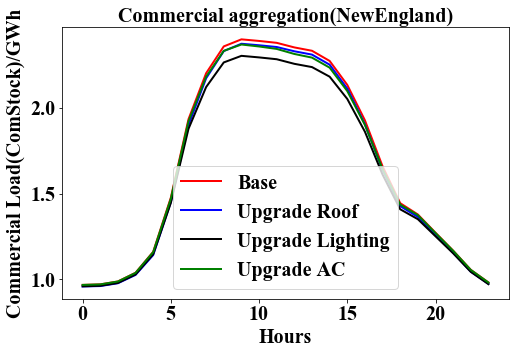

In [8]:
if Switch_usingComStock_test == 1:
    title_name = 'Commercial aggregation('+Region+ ')'
    figsize = 8,5
    figure, ax = plt.subplots(figsize=figsize)
    hours= [x for x in range(0,24)]
    kW_GW_multip = 0.000001

    A,=plt.plot(hours,df_system_com_scale_base.groupby('hour').mean()['out.electricity.total.energy_consumption']*kW_GW_multip,'-r',label='Base',linewidth=2.0)
    B,=plt.plot(hours,df_system_com_scale_upadtedR30.groupby('hour').mean()['out.electricity.total.energy_consumption']*kW_GW_multip,'-b',label='Upgrade Roof',linewidth=2.0)
    C,=plt.plot(hours,df_system_com_scale_upadtedlighting.groupby('hour').mean()['out.electricity.total.energy_consumption']*kW_GW_multip,'-k',label='Upgrade Lighting',linewidth=2.0)
    D,=plt.plot(hours,df_system_com_scale_upadtedAC.groupby('hour').mean()['out.electricity.total.energy_consumption']*kW_GW_multip,'-g',label='Upgrade AC',linewidth=2.0)

    font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 20,
    }
    font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 20,
    }
    # legend = plt.legend(handles=[A,B,C,D],prop=font1, bbox_to_anchor=[1.04,1])
    legend = plt.legend(handles=[A,B,C,D],prop=font1)

    plt.tick_params(labelsize=20)
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]

    plt.xlabel('Hours',font2)
    plt.ylabel('Commercial Load(ComStock)/GWh',font2)
    plt.title(title_name,font1) 
    # plt.xticks([1, 3, 5,7,9,11])
    plt.show()

In [9]:
if Switch_usingComStock_test == 1:
    pass
elif Switch_usingComStock_test == 0:
    #load the aggregated DMP data
    df_building_agg_WSBT_typeReplaced = pd.read_csv('Outputs/s5_'+ Region +'_commercial_locally_afterMapAggregate_WSID.csv')
    factor_count = df_building_agg_WSBT_typeReplaced.iloc[0]['All Count # (Raw) Remove Exclude']/(df_building_agg_WSBT_typeReplaced.iloc[0]['All Count # (WithoutNan_ZipBSqft_EXCLUDE)'])

    #load buiding type summary
    df_OpenEI_summary = pd.read_csv('Inputs/OpenEI_model.csv')
    # Begin to calculate the system level commercial load
    systemload_list = list(np.zeros(8760))
    # Query the OpenEI commercial load
    data_direi = r'../Shared Drives/BTO Topic 2  Integrating EE & DR/Task 2/Load_Shape_Data/OPEN_EI/*'
    files = glob.glob(data_direi)
    wsid_unique_dmp = df_building_agg_WSBT_typeReplaced['Matched weather station'].unique().tolist()

    df_system_com = pd.DataFrame()
    for i in range(0,len(wsid_unique_dmp)):
        if i == int(0.2*len(wsid_unique_dmp)) or i == int(0.6*len(wsid_unique_dmp)):
            print('Now is launching the '+ str(i)+ '/(' + str(len(wsid_unique_dmp)) + ')')

        WSid_str = str(wsid_unique_dmp[i])
        df_sameWSid = df_building_agg_WSBT_typeReplaced[df_building_agg_WSBT_typeReplaced['Matched weather station']== int(WSid_str)]

        folder_dir = [x for x in files if WSid_str in x]
        datafile_list = glob.glob(folder_dir[0]+'/*')    
        for j in range(0,len(df_sameWSid)):

            keyword_loadfile_raw = df_sameWSid.iloc[j]['Mapped OpenEI building type']
            keyword_loadfile =  df_sameWSid.iloc[j]['Mapped OpenEI building type new']
            file_full_dir = [x for x in datafile_list if keyword_loadfile in x]
            index_id = list(df_OpenEI_summary['BUILDING TYPE NAME']).index(keyword_loadfile_raw)
            factor_area = df_sameWSid.iloc[j]['TotalBuildingSqft']/(list(df_OpenEI_summary['FLOOR AREA (FT2)'])[index_id])

            # read the csv file
            unit_load = pd.read_csv(file_full_dir[0])

            if i ==0 and j==0:
                df_system_com['Date/Time'] = unit_load['Date/Time'].tolist()

            unit_column_list = unit_load.columns.tolist()[1:]
            for k in unit_column_list:
                unit_load[k] = [x*factor_area*factor_count for x in unit_load[k]]
                if k in df_system_com.columns:
                    df_system_com[k] = list(map(lambda x: x[0]+x[1], zip(df_system_com[k], unit_load[k])))
                else:
                    df_system_com[k] = unit_load[k]
    systemload_list_commercial = df_system_com['Electricity:Facility [kW](Hourly)'].tolist()
    systemload_list_commercial_leap = AverageToLeapYear(systemload_list_commercial)

# 2. Build the system load - Residential

In [10]:
df_ScalingFactor = pd.read_csv('For_ScalingFactor_begin_Res.csv')
# Scale_UsableRatio,  Scale_BuildingCount,  Scale_EIARefer

In [11]:
if Switch_usingResStock_test ==0:
    df_resstock_raw = pd.read_csv(r'../Shared Drives/GEB Potential Study (NREL_LBNL)/Nov15_baseline_selected_locs.csv')
    # Downsample the raw NREL data, from 15 minutes to 1 hour
    columns_list = df_resstock_raw.columns.tolist()
    df_resstock = pd.DataFrame()

    for i in range(len(columns_list)):
        if i<=1 or i>=38:
            tem_column = [x for x in df_resstock_raw[columns_list[i]].tolist()[3::4]]
        else:
            column_value_list = df_resstock_raw[columns_list[i]].tolist()
            tem_column = []
            for j in range(0,len(column_value_list),4):
    #             tem_column.append(sum(column_value_list[j:j+4]))
                tem_column.append(np.mean(column_value_list[j:j+4]))
        df_resstock[columns_list[i]] =  tem_column
        
elif Switch_usingResStock_test ==1:
    df_resstock = pd.read_csv('../Shared Drives/NREL_ResStock_Test/Test12_perbldgresults.csv')
elif Switch_usingResStock_test ==2:
#     df_resstock = pd.read_csv('../Shared Drives/NREL_ResStock_0306/LBNL run results.csv')    
    df_resstock = pd.read_csv('../Shared Drives/NREL_ResStock_0617/lbnl_geb_support_revamp4.csv')  
elif Switch_usingResStock_test ==3:
    df_resstock = pd.read_csv('../Shared Drives/NREL_ResStock_0507/Revamp Test Run.csv')  

In [12]:
Region

'NewEngland'

In [13]:
#load the residential data

# df_resstock_number = pd.read_csv('Outputs/S6_'+ Region +'_Residential_summary.csv')
if switch_USacross ==1:
    df_resstock_number = pd.read_csv('Outputs/S6_'+ Region +'_Residential_summary_new_USMatch.csv')
elif switch_USacross ==0:
    df_resstock_number = pd.read_csv('Outputs/S6_'+ Region +'_Residential_summary_new_StateMatch.csv')
elif switch_USacross ==2:
    df_resstock_number = pd.read_csv('Outputs/S6_'+ Region +'_Residential_summary_new_RMsubregions.csv') 
    if Switch_usingResStock_test ==2:
#         result_average_sqft_detail = pd.read_csv('Inputs/AverageSQFT_summary_ResStock_full_0306.csv')
        result_average_sqft_detail = pd.read_csv('Inputs/AverageSQFT_summary_ResStock_full_0617.csv')
    if Switch_usingResStock_test ==3:
        result_average_sqft_detail = pd.read_csv('Inputs/AverageSQFT_summary_ResStock_test_0507.csv')

if Switch_usingResStock_test ==0:
    df_ResStock_weatherstation = pd.read_csv('Inputs/ResStock 2012 AMYs (splited).csv')
elif Switch_usingResStock_test >=1:    
    df_ResStock_weatherstation = pd.read_csv('Inputs/Mapping_NREL_City_formats.csv')
    ID1_list = df_ResStock_weatherstation['ID1'].tolist()
    epw_list = df_ResStock_weatherstation['epw'].tolist()
    USAF_list = df_ResStock_weatherstation['USAF'].tolist()

scale_factor_usable_raw = df_resstock_number.iloc[0]['All raw number_RmExclude']/(df_resstock_number['Count_EachWS_RMExclude_RMNaNzip_RMunmatched'].sum())

In [14]:
scale_usable = [scale_factor_usable_raw for x in range(len(df_ScalingFactor))]
df_ScalingFactor['Scale_UsableRatio'] = scale_usable

In [15]:
scale_count = [0 for x in range(len(df_ScalingFactor))]
df_system_res = pd.DataFrame()

for i in range(len(df_resstock_number)):
#     print(i)
    station_id = df_resstock_number.loc[i]['Weather Station id']
    if station_id == 120110:
        print(str(station_id)+' is replaced by the ')
        station_id =101017   
        print(str(station_id))
    elif station_id == 210592:
        print(str(station_id)+' is replaced by the ')
        station_id =215768   
        print(str(station_id))
    elif station_id == 749293:
        print(str(station_id)+' is replaced by the ')
        station_id =215768   
        print(str(station_id))        
        
    if station_id == 111111:
        continue
    elif station_id == 142626:
        print(str(station_id)+' is replaced by the ')
        station_id =165368   
        print(str(station_id))
    elif station_id == 247402:
        print(str(station_id)+' is replaced by the ')
        station_id =215768
        print(str(station_id))
    elif station_id == 368181:
        print(str(station_id)+' is replaced by the ')
        station_id =268333
        print(str(station_id))
    elif station_id == 434720:
        print(str(station_id)+' is replaced by the ')
        station_id =544930
        print(str(station_id))
    elif station_id == 742491:
        print(str(station_id)+' is replaced by the ')
        station_id =753608
        print(str(station_id))
    elif station_id == 766075:
        print(str(station_id)+' is replaced by the ')
        station_id =721297   
        print(str(station_id))
        
    # Translate the format from data 0 to data 1
    index_file = ID1_list.index(station_id)
    epw = epw_list[index_file]
    df_resstock_same_stationid = df_resstock[df_resstock['epw']==epw]
    unique_bt_list = df_resstock_same_stationid['unit_type'].unique().tolist()
    ut_name = df_resstock_number.loc[i]['Mapped OpenEI building type']
    
    tem_a = result_average_sqft_detail[result_average_sqft_detail['weather_station']==epw]
    if ut_name in unique_bt_list:
        df_resstock_epw_ut = df_resstock_same_stationid[df_resstock_same_stationid['unit_type']==ut_name]
        df_resstock_epw_ut = df_resstock_epw_ut[df_resstock_epw_ut['upgrade']==upgrade_Base]
        if Switch_usingResStock_test ==1 or Switch_usingResStock_test == 0:
            scale_factor = df_resstock_number.iloc[i]['Count_EachWS_RMExclude_RMNaNzip_RMunmatched']
        elif Switch_usingResStock_test ==2 or Switch_usingResStock_test ==3:
            temm_total_sqft = df_resstock_number.iloc[i]['BUILDING_SQFT_sum']
            
            tem_b = tem_a[tem_a['building_type']==ut_name]
            average_sqft = tem_b.iloc[0][key_string]
            scale_factor = temm_total_sqft/average_sqft
        
        tem_a = df_ScalingFactor[df_ScalingFactor['epw']== epw]
        list_id = (tem_a[tem_a['unit_type']==ut_name].index).tolist()[0]
        scale_count[list_id]=scale_count[list_id]+scale_factor
    
        if i ==0:
            df_system_res['epw'] = df_resstock_epw_ut['epw'].tolist()
            df_system_res['time'] = df_resstock_epw_ut['time'].tolist()

            
        unit_column_list = df_resstock_epw_ut.columns.tolist()[5:7]
        for k in unit_column_list:
            df_resstock_epw_ut[k] = [x*scale_factor*scale_factor_usable_raw for x in df_resstock_epw_ut[k]]

            if k in df_system_res.columns:
                df_system_res[k] = list(map(lambda x: x[0]+x[1], zip(df_system_res[k].tolist(), df_resstock_epw_ut[k].tolist())))
            else:
                df_system_res[k] = df_resstock_epw_ut[k].tolist()
    else:
        print('DMP data does not have the building type (' + df_resstock_number.loc[i]['Mapped OpenEI building type'] + ') for station:('+str(station_id) + ')')
               
systemload_list_residential  = df_system_res['Building_Electricity'].tolist()

df_ScalingFactor['Scale_BuildingTot_area'] = scale_count

In [16]:
# Calculate the EE scenario
scale_count = [0 for x in range(len(df_ScalingFactor))]
df_system_res = pd.DataFrame()

for i in range(len(df_resstock_number)):
#     print(i)
    station_id = df_resstock_number.loc[i]['Weather Station id']
    if station_id == 120110:
        print(str(station_id)+' is replaced by the ')
        station_id =101017   
        print(str(station_id))
    elif station_id == 210592:
        print(str(station_id)+' is replaced by the ')
        station_id =215768   
        print(str(station_id))
    elif station_id == 749293:
        print(str(station_id)+' is replaced by the ')
        station_id =215768   
        print(str(station_id))        
        
    if station_id == 111111:
        continue
    elif station_id == 142626:
        print(str(station_id)+' is replaced by the ')
        station_id =165368   
        print(str(station_id))
    elif station_id == 247402:
        print(str(station_id)+' is replaced by the ')
        station_id =215768
        print(str(station_id))
    elif station_id == 368181:
        print(str(station_id)+' is replaced by the ')
        station_id =268333
        print(str(station_id))
    elif station_id == 434720:
        print(str(station_id)+' is replaced by the ')
        station_id =544930
        print(str(station_id))
    elif station_id == 742491:
        print(str(station_id)+' is replaced by the ')
        station_id =753608
        print(str(station_id))
    elif station_id == 766075:
        print(str(station_id)+' is replaced by the ')
        station_id =721297   
        print(str(station_id))
        
    # Translate the format from data 0 to data 1
    index_file = ID1_list.index(station_id)
    epw = epw_list[index_file]
    df_resstock_same_stationid = df_resstock[df_resstock['epw']==epw]
    unique_bt_list = df_resstock_same_stationid['unit_type'].unique().tolist()
    ut_name = df_resstock_number.loc[i]['Mapped OpenEI building type']
    
    tem_a = result_average_sqft_detail[result_average_sqft_detail['weather_station']==epw]
    if ut_name in unique_bt_list:
        df_resstock_epw_ut = df_resstock_same_stationid[df_resstock_same_stationid['unit_type']==ut_name]
        df_resstock_epw_ut = df_resstock_epw_ut[df_resstock_epw_ut['upgrade']==upgrade_EE]
        if Switch_usingResStock_test ==1 or Switch_usingResStock_test == 0:
            scale_factor = df_resstock_number.iloc[i]['Count_EachWS_RMExclude_RMNaNzip_RMunmatched']
        elif Switch_usingResStock_test ==2 or Switch_usingResStock_test ==3:
            temm_total_sqft = df_resstock_number.iloc[i]['BUILDING_SQFT_sum']
            
            tem_b = tem_a[tem_a['building_type']==ut_name]
            average_sqft = tem_b.iloc[0][key_string]
            scale_factor = temm_total_sqft/average_sqft
        
        tem_a = df_ScalingFactor[df_ScalingFactor['epw']== epw]
        list_id = (tem_a[tem_a['unit_type']==ut_name].index).tolist()[0]
        scale_count[list_id]=scale_count[list_id]+scale_factor
    
        if i ==0:
            df_system_res['epw'] = df_resstock_epw_ut['epw'].tolist()
            df_system_res['time'] = df_resstock_epw_ut['time'].tolist()

        unit_column_list = df_resstock_epw_ut.columns.tolist()[5:7]
        for k in unit_column_list:              
            df_resstock_epw_ut[k] = [x*scale_factor*scale_factor_usable_raw for x in df_resstock_epw_ut[k]]

            if k in df_system_res.columns:
                df_system_res[k] = list(map(lambda x: x[0]+x[1], zip(df_system_res[k].tolist(), df_resstock_epw_ut[k].tolist())))
            else:
                df_system_res[k] = df_resstock_epw_ut[k].tolist()
    else:
        print('DMP data does not have the building type (' + df_resstock_number.loc[i]['Mapped OpenEI building type'] + ') for station:('+str(station_id) + ')')
               
systemload_list_residential_EE = df_system_res['Building_Electricity'].tolist()

## 3. Build the dataframe which contains the commercial and residential

In [17]:
systemload_list_com_res = list(map(lambda x: x[0]+x[1], zip(systemload_list_commercial_leap, systemload_list_residential)))

systemload2 = pd.DataFrame()
dt1 = pd.date_range(start="20160101", end="20170102", freq="H")  # freq="D"represent the frequency is hour
dt1 = dt1[0:-1]
systemload2['Date/Time']= dt1

systemload = pd.DataFrame()
systemload = systemload2.iloc[1:8785]
systemload.index = range(len(systemload))

hourfield = 'hour'
year = 2016
systemload = systemload.reset_index().rename({'index':'hour'}, axis=1)
systemload['hour'] = systemload['hour']+1
systemload['hour'] = systemload['hour'].astype(float)
systemload['day_of_year'] = np.ceil(systemload[hourfield]/24).astype(int)
dt = datetime.datetime(year,1,1,0,0)
systemload['date'] = dt
for ind in systemload.index:
    hours=systemload.loc[ind, hourfield]-1
    dtdelta = datetime.timedelta(hours = hours)
    systemload.loc[ind,'date'] = dt+dtdelta
systemload['month'] = systemload['date'].dt.month        
# systemload.drop('Date/Time', axis=1, inplace=True)
systemload['weekend'] = systemload['date'].dt.weekday>4
systemload['hour'] = systemload['date'].dt.hour

systemload['commercial_load_kwh'] = systemload_list_commercial_leap
systemload['residential_load_kwh'] = systemload_list_residential
systemload['ComAndRes_load_kwh'] =systemload_list_com_res

if Switch_EEconsidered ==1:
    systemload['residential_load_kwh_EE'] = systemload_list_residential_EE

In [18]:
systemload_test = systemload.copy()
systemload_raw = systemload.copy()
    
if Switch_daylight == 1:    
    hourlist = systemload_test['hour'].tolist()
    commercial_load_kwh_list = systemload_test['commercial_load_kwh'].tolist()
    residential_load_kwh_list = systemload_test['residential_load_kwh'].tolist()
    ComAndRes_load_kwh_list = systemload_test['ComAndRes_load_kwh'].tolist()
    if Switch_EEconsidered ==1:
        residential_load_kwh_list_EE = systemload_test['residential_load_kwh_EE'].tolist()

    for i in range(len(hourlist)):
        if 7<=hourlist[i] and hourlist[i] <=21:
            pass
        else:
            commercial_load_kwh_list[i] = 0
            residential_load_kwh_list[i] = 0
            ComAndRes_load_kwh_list[i] = 0
            if Switch_EEconsidered ==1:
                residential_load_kwh_list_EE[i] = 0

    systemload_test['commercial_load_kwh'] = commercial_load_kwh_list
    systemload_test['residential_load_kwh'] = residential_load_kwh_list
    systemload_test['ComAndRes_load_kwh'] = ComAndRes_load_kwh_list
    if Switch_EEconsidered ==1:
        systemload_test['residential_load_kwh_EE'] = residential_load_kwh_list_EE
    systemload = systemload_test.copy()

systemload.to_csv('Result_Systemload/SystemLoad_' + Region+'_AcrossUS('+ str(switch_USacross) +')_0228.csv',index = False)

Plot the result

Plot the overall plots

## 4. Read the EIA data(hourly measured demand load, refer to this hourly load data)

In [19]:
if region_id==0:
    CA_load_measured = pd.read_csv('Inputs/Demand_for_California_(region)_hourly_-_local_time.csv')
    CA_load_measured = CA_load_measured.rename(columns={'Demand for California (region) hourly - local time': 'Time','Unnamed: 1':'Load/MW'})
    IID_load_measured = pd.read_csv('Inputs/Demand_for_Imperial_Irrigation_District_hourly_local_time.csv')
    IID_load_measured = IID_load_measured.rename(columns={'Demand for Imperial Irrigation District (IID) hourly - local time': 'Time','Unnamed: 1':'Load/MW'})
elif region_id==1:
    CA_load_measured = pd.read_csv('Inputs/Demand_for_Texas_(region)_hourly_-_local_time.csv')
    CA_load_measured = CA_load_measured.rename(columns={'Demand for Texas (region) hourly - local time': 'Time','Unnamed: 1':'Load/MW'})
elif region_id==2:
    CA_load_measured = pd.read_csv('Inputs/Demand_for_New_England_(region)_hourly_-_local_time.csv')
    CA_load_measured = CA_load_measured.rename(columns={'Demand for New England (region) hourly - local time': 'Time','Unnamed: 1':'Load/MW'})
    
CA_load_measured = CA_load_measured.iloc[4:]
CA_load_measured_copy = CA_load_measured.copy()

time_list = CA_load_measured_copy['Time']
newcolumn_list = [datetime.datetime.strptime(x, '%m/%d/%y %H:%M') for x in time_list]
CA_load_measured_copy['Time_dateframe'] = newcolumn_list

if region_id==0:
    IID_load_measured = IID_load_measured.fillna(0)
    IID_load_measured = IID_load_measured.iloc[4:]
    IID_load_measured_copy = IID_load_measured.copy()

    time_list = IID_load_measured_copy['Time']
    newcolumn_list2 = [datetime.datetime.strptime(x, '%m/%d/%y %H:%M') for x in time_list]
    IID_load_measured_copy['Time_dateframe'] = newcolumn_list2
    IID_load_measured_copy.sort_values(by=['Time_dateframe'], inplace=True)
CA_load_measured_copy.sort_values(by=['Time_dateframe'], inplace=True)
if Switch_year2016 ==1:
    yearly_data = CA_load_measured_copy[(CA_load_measured_copy['Time_dateframe'] >= '2016-1-1') & (CA_load_measured_copy['Time_dateframe'] <= '2017-01-01')]
    yearly_data = yearly_data.iloc[1:]
    if region_id==0:
        yearly_data_IID = IID_load_measured_copy[(IID_load_measured_copy['Time_dateframe'] >= '2016-1-1') & (IID_load_measured_copy['Time_dateframe'] <= '2017-01-01')]
        yearly_data_IID = yearly_data_IID.iloc[1:]
        load_list = [int(x) for x in yearly_data['Load/MW'].tolist()]
        a = yearly_data['Time_dateframe'].tolist()
        for i in range(len(yearly_data_IID)):            
            index_time = a.index(yearly_data_IID.iloc[i][2])
            load_list[index_time] = load_list[index_time]-int(yearly_data_IID.iloc[i][1])
        yearly_data['Load/MW'] = load_list
    
elif Switch_year2016 ==0:
    if region_id==0 or region_id==2:
        yearly_data = CA_load_measured_copy[(CA_load_measured_copy['Time_dateframe'] >= '2018-1-1') & (CA_load_measured_copy['Time_dateframe'] <= '2019-01-01')]
    if region_id==1:    
        yearly_data = CA_load_measured_copy[(CA_load_measured_copy['Time_dateframe'] >= '2019-1-1') & (CA_load_measured_copy['Time_dateframe'] <= '2020-01-01')]

if Switch_ReadERCO_CMAX_hourly == 1:
    if region_id==0:
        ERCO_hourly = pd.read_csv('Inputs/SeriesExport-04-07-CA.csv')
        delta_hours = 7
        index_id = ERCO_hourly['Series Key'].tolist().index('20170101T00Z')
        index_id = index_id - delta_hours
        ERCO_hourly = ERCO_hourly.iloc[index_id:index_id+8784]
        ERCO_hourly = ERCO_hourly.sort_index(ascending=False)
        ERCO_hourly['Time'] = yearly_data['Time'].tolist()
        ERCO_hourly['month'] = systemload['month'].tolist()
        
        ERCO_hourly = ERCO_hourly.fillna(0)
        int_list = ERCO_hourly['EBA.CAL-ALL.D.H'].tolist()
        for j in range(len(int_list)):
            int_list[j] = int(int_list[j])
        ERCO_hourly['EBA.CAL-ALL.D.H'] = int_list        
        EMM_hourly = ERCO_hourly.copy()
        
    elif region_id==1:
        ERCO_hourly = pd.read_csv('Inputs/SeriesExport-03-31-2020-19-03-17_ERCO.csv')
        delta_hours = 5
        index_id = ERCO_hourly['Series Key.1'].tolist().index('20170101T00Z')
        index_id = index_id - delta_hours
        ERCO_hourly = ERCO_hourly.iloc[index_id:index_id+8784]
        ERCO_hourly = ERCO_hourly.sort_index(ascending=False)
        ERCO_hourly['Time'] = yearly_data['Time'].tolist()
        ERCO_hourly['month'] = systemload['month'].tolist()
        
        ERCO_hourly = ERCO_hourly.fillna(0)
        int_list = ERCO_hourly['EBA.ERCO-ALL.D.H'].tolist()
        for j in range(len(int_list)):
            int_list[j] = int(int_list[j])
        ERCO_hourly['EBA.ERCO-ALL.D.H'] = int_list        
        EMM_hourly = ERCO_hourly.copy()
    elif region_id==2:
        EMM_hourly = yearly_data.copy()
        EMM_hourly = EMM_hourly.rename(columns={'Load/MW':'EBA.NEWE-ALL.D.H'})
        int_list = EMM_hourly['EBA.NEWE-ALL.D.H'].tolist()
        for j in range(len(int_list)):
            int_list[j] = int(int_list[j])
        EMM_hourly['EBA.NEWE-ALL.D.H'] = int_list         
        EMM_hourly['month'] = systemload['month'].tolist()

yearly_data_list = [int(x) for x in list(yearly_data['Load/MW'])] # The last value is the first hour value of next year, so not be included        
yearly_data_list_raw = copy.copy(yearly_data_list)

## Ranking the load values

In [20]:
df_system_load_raw_backup = systemload_raw.copy()

df_EIA = systemload.copy()
df_EIA = df_EIA.drop(columns=['commercial_load_kwh', 'residential_load_kwh','ComAndRes_load_kwh'])
df_EIA['EIA load/MW'] = yearly_data_list_raw

df_EIA_366days = df_EIA.groupby('day_of_year').mean()
df_calc_366days_res = systemload_raw.groupby('day_of_year').mean()

if Switch_res_ranking ==1 and Switch_EEconsidered ==1:    
    df_system_load_sorted = pd.DataFrame()
    for i in range(1,13):
        df_EIA_month =  df_EIA_366days[df_EIA_366days['month']==i]    
        EIA_sort_index_list = np.argsort(df_EIA_month['EIA load/MW'].tolist()).tolist()
        df_calc_366days_res_month = df_calc_366days_res[df_calc_366days_res['month']==i]  
        res_load_month_list = df_calc_366days_res_month['residential_load_kwh_EE'].tolist()
        Calc_sort_index_list = np.argsort(res_load_month_list).tolist()

        for j in range(0,len(EIA_sort_index_list)):
            index_sort = EIA_sort_index_list.index(j)
            row_id = Calc_sort_index_list[index_sort]
            day_id = df_calc_366days_res_month.index[row_id]
            df_system_load_sorted = pd.concat([df_system_load_sorted,systemload_raw[systemload_raw['day_of_year']==day_id]])
    systemload_raw['residential_load_kwh_EE_ranking'] = df_system_load_sorted['residential_load_kwh_EE'].tolist()

if Switch_res_ranking ==1:    
    df_system_load_sorted = pd.DataFrame()
    for i in range(1,13):
        df_EIA_month =  df_EIA_366days[df_EIA_366days['month']==i]    
        EIA_sort_index_list = np.argsort(df_EIA_month['EIA load/MW'].tolist()).tolist()
        df_calc_366days_res_month = df_calc_366days_res[df_calc_366days_res['month']==i]  
        res_load_month_list = df_calc_366days_res_month['residential_load_kwh'].tolist()
        Calc_sort_index_list = np.argsort(res_load_month_list).tolist()

        for j in range(0,len(EIA_sort_index_list)):
            index_sort = EIA_sort_index_list.index(j)
            row_id = Calc_sort_index_list[index_sort]
            day_id = df_calc_366days_res_month.index[row_id]
            df_system_load_sorted = pd.concat([df_system_load_sorted,systemload_raw[systemload_raw['day_of_year']==day_id]])
    systemload_raw['residential_load_kwh_ranking'] = df_system_load_sorted['residential_load_kwh'].tolist()
    
if Switch_com_ranking ==1:    
    df_system_load_sorted = pd.DataFrame()
    for i in range(1,13):
        df_EIA_month =  df_EIA_366days[df_EIA_366days['month']==i]    
        EIA_sort_index_list = np.argsort(df_EIA_month['EIA load/MW'].tolist()).tolist()
        df_calc_366days_res_month = df_calc_366days_res[df_calc_366days_res['month']==i]  
        res_load_month_list = df_calc_366days_res_month['commercial_load_kwh'].tolist()
        Calc_sort_index_list = np.argsort(res_load_month_list).tolist()

        for j in range(0,len(EIA_sort_index_list)):
            index_sort = EIA_sort_index_list.index(j)
            row_id = Calc_sort_index_list[index_sort]
            day_id = df_calc_366days_res_month.index[row_id]
            df_system_load_sorted = pd.concat([df_system_load_sorted,systemload_raw[systemload_raw['day_of_year']==day_id]])

    systemload_raw['commercial_load_kwh_ranking'] = df_system_load_sorted['commercial_load_kwh'].tolist()

In [21]:
if Switch_daylight ==1:
    for i in range(len(hourlist)):
        if 7<=hourlist[i] and hourlist[i] <=21:
            pass
        else:
            yearly_data_list[i] = 0

In [22]:
systemload_raw['Raw EIA load/MW']  = yearly_data_list_raw
systemload_raw['Daytime EIA load/MW']  = yearly_data_list

yearly_data_list_KW = [x*1000 for x in yearly_data_list]
yearly_data_list_raw_KW = [x*1000 for x in yearly_data_list_raw]

otherload_MW=list(map(lambda x :x[0]-x[1]-x[2] ,zip(yearly_data_list_raw_KW,systemload['commercial_load_kwh'].tolist(),systemload['residential_load_kwh'].tolist())))
systemload_raw['raw other load/KW'] = otherload_MW

systemload_average = systemload.groupby('hour').mean()

## 5. Read the EIA 861 category data(Refer to the commercial ratio, residential ratio)

In [23]:
if Switch_monthlyScaling ==0:
    if Switch_year2016==1:
        EIA_861 = pd.read_csv('Inputs/Sales_Ult_Cust_2016.csv')
    elif Switch_year2016==0:
        EIA_861 = pd.read_csv('Inputs/Sales_Ult_Cust_2018.csv')  

    # Filter the relevant region
    # TBD: Need to be revised to the Balance Authority regions
    if region_id==0 or region_id==1 :
        df_OneState = EIA_861[EIA_861['State']==Region_list[region_id]]
    if region_id==2:
        df_OneState=pd.DataFrame()
        for state in ['CT','MA','ME','NH','RI','VT']:
            df_OneState_each = EIA_861[EIA_861['State']==state]
            df_OneState = pd.concat([df_OneState,df_OneState_each])

    # Wash the data, some data is dot, not a value    
    # a) wash the residential data(EIA data, but not the hourly data)
    list_column = (df_OneState.RESIDENTIALMegawatthours.tolist())
    list_column_new = []
    for x in list_column:
        if x == '.':
            list_column_new.append(0)
        else:
            list_column_new.append(int(x))

    all_daily_Res_GWh = sum(list_column_new)
    print('=======The following is the EIA 861 details=====')

    print('   ')
    print('    The annual sum MWh(Res) is ' + str(all_daily_Res_GWh))
    average_daily_Res_GWh = sum(list_column_new)/365/1000/24
    print('    The daily average sum GWh(Res) is ' + str(average_daily_Res_GWh))

    # b) wash the commercial data(EIA data, but not the hourly data)
    list_column = (df_OneState.COMMERCIALMegawatthours.tolist())
    list_column_new = []
    for x in list_column:
        if x == '.':
            list_column_new.append(0)
        else:
            list_column_new.append(int(x))
    print('   ')
    all_daily_Com_GWh = sum(list_column_new)
    print('    The annual sum MWh(Com) is ' + str(all_daily_Com_GWh))
    average_daily_Com_GWh = sum(list_column_new)/365/1000/24
    print('    The daily average sum GWh(Com) is ' + str(average_daily_Com_GWh))

    # c) wash the total data(EIA data, but not the hourly data)
    list_column = (df_OneState.TOTALMegawatthours.tolist())
    list_column_new = []
    for x in list_column:
        if x == '.':
            list_column_new.append(0)
        else:
            list_column_new.append(int(x))
    print('   ')
    all_daily_GWh = sum(list_column_new)
    print('    The annual sum MWh(total) is ' + str(all_daily_GWh))
    average_daily_total_GWh = sum(list_column_new)/365/1000/24
    print('    The daily average sum GWh(total) is ' + str(average_daily_total_GWh))

    K_Res = all_daily_Res_GWh/all_daily_GWh
    K_Com = all_daily_Com_GWh/all_daily_GWh
    K_Other = 1 - K_Com - K_Res

    print('The EIA ratio of Res load is ' + str(round(K_Res*100,2))+'%')
    print('The EIA ratio of Com load is ' + str(round(K_Com*100,2))+'%')
    
# elif Switch_monthlyScaling ==1:

if region_id==0:
    month_ratios = pd.read_csv('Inputs/SeriesExport-04-07-category_CA.csv') 
    index_id = month_ratios['Series Key.1'].tolist().index('201612')
    month_ratios = month_ratios.iloc[index_id:index_id+12]
    month_ratios = month_ratios.sort_index(ascending=False)
    month_ratios['ELEC.SALES.CA-RES.M'] = [float(x) for x in month_ratios['ELEC.SALES.CA-RES.M'].tolist()]
    month_ratios['ELEC.SALES.CA-COM.M'] = [float(x) for x in month_ratios['ELEC.SALES.CA-COM.M'].tolist()]
    month_ratios['ELEC.SALES.CA-IND.M'] = [float(x) for x in month_ratios['ELEC.SALES.CA-IND.M'].tolist()] 
elif region_id==1:
    month_ratios = pd.read_csv('Inputs/SeriesExport-03-31-category_TX.csv') 
    index_id = month_ratios['Series Key.1'].tolist().index('201612')
    month_ratios = month_ratios.iloc[index_id:index_id+12]
    month_ratios = month_ratios.sort_index(ascending=False)
    month_ratios['ELEC.SALES.TX-RES.M'] = [float(x) for x in month_ratios['ELEC.SALES.TX-RES.M'].tolist()]
    month_ratios['ELEC.SALES.TX-COM.M'] = [float(x) for x in month_ratios['ELEC.SALES.TX-COM.M'].tolist()]
    month_ratios['ELEC.SALES.TX-IND.M'] = [float(x) for x in month_ratios['ELEC.SALES.TX-IND.M'].tolist()]        
elif region_id==2:
    for state in ['CT','MA','ME','NH','RI','VT']:
        month_ratio = pd.read_csv('Inputs/SeriesExport-04-08-2020-'+state + '_Category.csv')
        index_id = month_ratio['Series Key.1'].tolist().index('201612')
        month_ratio = month_ratio.iloc[index_id:index_id+12]
        month_ratio = month_ratio.sort_index(ascending=False)


        month_ratio['ELEC.SALES.'+state+'-RES.M'] = [float(x) for x in month_ratio['ELEC.SALES.'+state+'-RES.M'].tolist()]
        month_ratio['ELEC.SALES.'+state+'-COM.M'] = [float(x) for x in month_ratio['ELEC.SALES.'+state+'-COM.M'].tolist()]
        month_ratio['ELEC.SALES.'+state+'-IND.M'] = [float(x) for x in month_ratio['ELEC.SALES.'+state+'-IND.M'].tolist()]  

        if state == 'CT':
            month_ratios = month_ratio.copy()
            month_ratios = month_ratios.rename(columns={'ELEC.SALES.'+state+'-RES.M': 'ELEC.SALES.NewEngland-RES.M','ELEC.SALES.'+state+'-COM.M': 'ELEC.SALES.NewEngland-COM.M','ELEC.SALES.'+state+'-IND.M': 'ELEC.SALES.NewEngland-IND.M'})
        else:
            month_ratios['ELEC.SALES.NewEngland-RES.M'] = list(map(lambda x: x[0]+x[1], zip(month_ratios['ELEC.SALES.NewEngland-RES.M'], month_ratio['ELEC.SALES.'+state+'-RES.M'])))
            month_ratios['ELEC.SALES.NewEngland-COM.M'] = list(map(lambda x: x[0]+x[1], zip(month_ratios['ELEC.SALES.NewEngland-COM.M'], month_ratio['ELEC.SALES.'+state+'-COM.M'])))
            month_ratios['ELEC.SALES.NewEngland-IND.M'] = list(map(lambda x: x[0]+x[1], zip(month_ratios['ELEC.SALES.NewEngland-IND.M'], month_ratio['ELEC.SALES.'+state+'-IND.M'])))

month_ratios.index = range(12)

=======The following is the EIA 861 details=====
   
    The annual sum MWh(Res) is 59092532
    The daily average sum GWh(Res) is 6.745722831050229
   
    The annual sum MWh(Com) is 89529725
    The daily average sum GWh(Com) is 10.220288242009133
   
    The annual sum MWh(total) is 179692566
    The daily average sum GWh(total) is 20.51285
The EIA ratio of Res load is 32.89%
The EIA ratio of Com load is 49.82%


## 6. Scale the load profiles based on the EIA hourly data

In [24]:
if Switch_monthlyScaling ==0:
    Annual_EIA_hourly_sum_GWh = sum(yearly_data_list_KW)/1000000
    if Switch_DayTimeScaling ==1:
        K_res = Annual_EIA_hourly_sum_GWh*K_Res/(systemload['residential_load_kwh'].sum()/1000000)
        K_com = Annual_EIA_hourly_sum_GWh*K_Com/(systemload['commercial_load_kwh'].sum()/1000000)
    elif Switch_DayTimeScaling ==0:
        K_res = Annual_EIA_hourly_sum_GWh*K_Res/(systemload_raw['residential_load_kwh'].sum()/1000000)
        K_com = Annual_EIA_hourly_sum_GWh*K_Com/(systemload_raw['commercial_load_kwh'].sum()/1000000)

    df_ScalingFactor['Scale_EIARefer'] = [K_res for x in range(len(df_ScalingFactor))]    
    df_ScalingFactor.to_csv('ScalingFactor(FullRun_ResStock_Data)_'+ Region +'.csv',index = False)

    if Switch_usingComStock_test == 1:
        df_com_ScalingFactor_base['Scale_EIARefer'] = [K_com for x in range(len(df_com_ScalingFactor_base))]
        df_com_ScalingFactor_base.to_csv('ScalingFactor(DryRun_ComStock_Data)_'+ Region +'.csv',index = False)
        
    Res_new_nighttime0 = [x*K_res  for x in systemload['residential_load_kwh'].tolist()]
    Com_new_nighttime0 = [x*K_com  for x in systemload['commercial_load_kwh'].tolist()]

    Res_new = [x*K_res  for x in systemload_raw['residential_load_kwh'].tolist()]
    Com_new = [x*K_com  for x in systemload_raw['commercial_load_kwh_ranking'].tolist()]
    Res_new_EE = [x*K_res  for x in systemload_raw['residential_load_kwh_EE'].tolist()]
    
elif Switch_monthlyScaling ==1:
    if region_id ==0:
        EMM_hourly_night0 = EMM_hourly['EBA.CAL-ALL.D.H'].tolist()    
    elif region_id ==1:
        EMM_hourly_night0 = EMM_hourly['EBA.ERCO-ALL.D.H'].tolist()
    elif region_id ==2:
        EMM_hourly_night0 = EMM_hourly['EBA.NEWE-ALL.D.H'].tolist()
    for i in range(len(hourlist)):
        if 7<=hourlist[i] and hourlist[i] <=21:
            pass
        else:
            EMM_hourly_night0[i] = 0
    if region_id ==0:
        EMM_hourly['CAL_nioght0'] = EMM_hourly_night0
    elif region_id ==1:
        EMM_hourly['ERCO_nioght0'] = EMM_hourly_night0        
    elif region_id ==2:
        EMM_hourly['NEWE_nioght0'] = EMM_hourly_night0          
    for i in range(1,13): 
        if region_id ==0:
            Month_EMM_hourly_sum_GWh = EMM_hourly[EMM_hourly['month']==i]['EBA.CAL-ALL.D.H'].sum()/1000  
            Month_EMM_night0_hourly_sum_GWh = EMM_hourly[EMM_hourly['month']==i]['CAL_nioght0'].sum()/1000  
        elif region_id ==1:
            Month_EMM_hourly_sum_GWh = EMM_hourly[EMM_hourly['month']==i]['EBA.ERCO-ALL.D.H'].sum()/1000  
            Month_EMM_night0_hourly_sum_GWh = EMM_hourly[EMM_hourly['month']==i]['ERCO_nioght0'].sum()/1000
        elif region_id ==2:
            Month_EMM_hourly_sum_GWh = EMM_hourly[EMM_hourly['month']==i]['EBA.NEWE-ALL.D.H'].sum()/1000  
            Month_EMM_night0_hourly_sum_GWh = EMM_hourly[EMM_hourly['month']==i]['NEWE_nioght0'].sum()/1000
            
        a = systemload_raw[systemload_raw['month']==i]
        b = systemload[systemload['month']==i]
        Month_EIA_hourly_sum_GWh = a['Raw EIA load/MW'].sum()/1000
        scale_StateToEMM = Month_EMM_hourly_sum_GWh/Month_EIA_hourly_sum_GWh

        K_Res = month_ratios.iloc[i-1][1]/(month_ratios.iloc[i-1][1]+month_ratios.iloc[i-1][3]+month_ratios.iloc[i-1][5])
        K_Com = month_ratios.iloc[i-1][3]/(month_ratios.iloc[i-1][1]+month_ratios.iloc[i-1][3]+month_ratios.iloc[i-1][5])
        K_Other = month_ratios.iloc[i-1][5]/(month_ratios.iloc[i-1][1]+month_ratios.iloc[i-1][3]+month_ratios.iloc[i-1][5])
        
        if Switch_DayTimeScaling ==1: # Only consider the daytime
            K_res = Month_EMM_night0_hourly_sum_GWh*K_Res/(b['residential_load_kwh'].sum()/1000000)
            K_com = Month_EMM_night0_hourly_sum_GWh*K_Com/(b['commercial_load_kwh'].sum()/1000000)
        elif Switch_DayTimeScaling ==0:# Consider all daytime 24h
            K_res = Month_EMM_hourly_sum_GWh*K_Res/(a['residential_load_kwh'].sum()/1000000)
            K_com = Month_EMM_hourly_sum_GWh*K_Com/(a['commercial_load_kwh'].sum()/1000000)
            
        if i==1:
            Res_new_nighttime0 = [x*K_res  for x in b['residential_load_kwh'].tolist()]
            Com_new_nighttime0 = [x*K_com  for x in b['commercial_load_kwh'].tolist()]
            Res_new = [x*K_res  for x in a['residential_load_kwh'].tolist()]
            Com_new = [x*K_com  for x in a['commercial_load_kwh_ranking'].tolist()]
            Res_new_EE = [x*K_res  for x in a['residential_load_kwh_EE'].tolist()] 
            EIA_EMMScal = [x*scale_StateToEMM for x in a['Raw EIA load/MW'].tolist()]
        else:
            Res_new_nighttime0 = Res_new_nighttime0+ [x*K_res  for x in b['residential_load_kwh'].tolist()]
            Com_new_nighttime0 = Com_new_nighttime0+[x*K_com  for x in b['commercial_load_kwh'].tolist()]
            Res_new = Res_new+[x*K_res  for x in a['residential_load_kwh'].tolist()]
            Com_new = Com_new+[x*K_com  for x in a['commercial_load_kwh_ranking'].tolist()]
            Res_new_EE = Res_new_EE + [x*K_res  for x in a['residential_load_kwh_EE'].tolist()] 
            EIA_EMMScal = EIA_EMMScal + [x*scale_StateToEMM for x in a['Raw EIA load/MW'].tolist()]

systemload_new = systemload_raw.copy()
systemload_new['scaled_res_kwh'] = Res_new
systemload_new['scaled_com_kwh'] = Com_new
systemload_new['scaled_res_kwh_nighttime0'] = Res_new_nighttime0
systemload_new['scaled_com_kwh_nighttime0'] = Com_new_nighttime0
systemload_new['scaled_res_kwh_EE'] = Res_new_EE
if Switch_monthlyScaling ==1:
    systemload_new['EIAtoEMM_mwh'] = EIA_EMMScal
    
scaled_otherload_kw=list(map(lambda x :x[0]-x[1]-x[2] ,zip(yearly_data_list_raw_KW,systemload_new['scaled_res_kwh'].tolist(),systemload_new['scaled_com_kwh'].tolist())))
systemload_new['scaled_other_load/KW'] = scaled_otherload_kw

if Switch_EEconsidered==1:
    yearly_data_list_KW_EE = list(map(lambda x: x[0]+x[1]+x[2],zip(systemload_new['scaled_res_kwh_EE'],systemload_new['scaled_com_kwh'],systemload_new['scaled_other_load/KW'])))
    yearly_data_list_MW_EE = [x/1000 for x in yearly_data_list_KW_EE]
    systemload_new['EIA load consider EE/MW'] = yearly_data_list_MW_EE
    print(str(round(sum(yearly_data_list_raw_KW)/sum(yearly_data_list_KW_EE)*100,3)) + '% (EIA/EIA_EE)')
    print(str(round(sum(systemload_new['scaled_res_kwh'])/sum(systemload_new['scaled_res_kwh_EE'])*100,3)) + '% (Res/Res_EE)')

112.648% (EIA/EIA_EE)
158.908% (Res/Res_EE)


In [25]:
# systemload_new.to_csv('Gross_load_'+ Region + '_' + Keyword2+'.csv',index = False)

if Switch_monthlyScaling ==0:
    systemload_new.to_csv('Gross_load_'+ Region + '_' + Keyword2 + str(Switch_monthlyScaling) +'.csv',index = False)

    df_systemload_brief = pd.DataFrame()
    df_systemload_brief['hour'] = systemload_new['hour']
    df_systemload_brief['other_load/KWh'] = systemload_new['scaled_other_load/KW']
    df_systemload_brief.to_csv('Other_load_'+ Region + '.csv',index = False)
    
    print('New scaled ratio:')
    print('    New scaled Res ratio is:' + str(systemload_new['scaled_res_kwh_nighttime0'].sum()/1000/systemload_new['Daytime EIA load/MW'].sum()))
    print('    New scaled Com ratio is:' + str(systemload_new['scaled_com_kwh_nighttime0'].sum()/1000/systemload_new['Daytime EIA load/MW'].sum()))
    print(' ')
    print('====To validate the scaling result(Up: scaled system load. Bottom: EIA861 category)====== ')
    K_Res = all_daily_Res_GWh/all_daily_GWh
    print('    The ratio(Res) is ' + str(K_Res))
    K_Com = all_daily_Com_GWh/all_daily_GWh
    print('    The ratio(Com) is ' + str(K_Com))
    K_Other = 1 - K_Com - K_Res
    print('    The ratio(Other) is ' + str(K_Other))

New scaled ratio:
    New scaled Res ratio is:0.3288535152867704
    New scaled Com ratio is:0.49823833558033775
 
====To validate the scaling result(Up: scaled system load. Bottom: EIA861 category)====== 
    The ratio(Res) is 0.3288535152867704
    The ratio(Com) is 0.4982383355803378
    The ratio(Other) is 0.17290814913289176


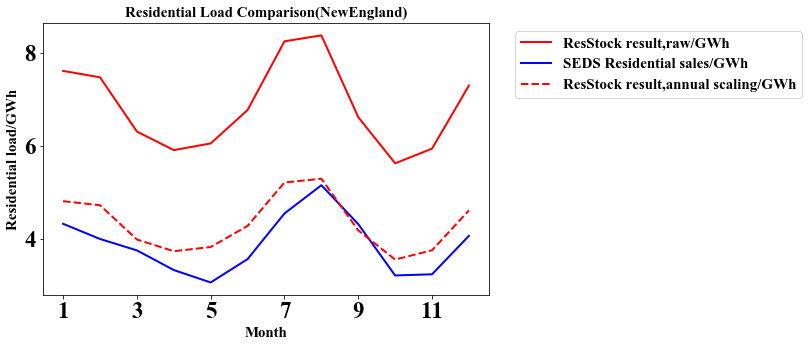

In [26]:
if Switch_compare ==1:
    result_monthly = pd.DataFrame()
    
#     systemload_new_annualraw = pd.read_csv('Gross_load_'+ Region + '_' + Keyword2+'_annualyearScale_test.csv')
    systemload_new_annualraw = pd.read_csv('Gross_load_'+ Region + '_' + Keyword2+ str(Switch_monthlyScaling) +'.csv')
    
    if region_id==0:
        aggregate_CA_raw = systemload_new_annualraw.groupby('month').mean()['scaled_res_kwh'].tolist()
        aggregate_CA_raw = [x/1000000 for x in aggregate_CA_raw]    
        result_monthly['month'] = systemload_raw.groupby('month').sum().index.tolist()
        result_monthly['Raw residential_load/GW'] = [x/1000000 for x in systemload_raw.groupby('month').mean()['residential_load_kwh'].tolist()]
        result_monthly['SEDS_category/GW'] = [x/1000 for x in month_ratios['ELEC.SALES.CA-RES.M'].tolist()]
        result_monthly['Aggregeated_annualscaling/GW'] = aggregate_CA_raw
    if region_id==1:
        aggregate_TX_raw = systemload_new_annualraw.groupby('month').mean()['scaled_res_kwh'].tolist()
        aggregate_TX_raw = [x/1000000 for x in aggregate_TX_raw]    
        result_monthly['month'] = systemload_raw.groupby('month').sum().index.tolist()
        result_monthly['Raw residential_load/GW'] = [x/1000000 for x in systemload_raw.groupby('month').mean()['residential_load_kwh'].tolist()]
        result_monthly['SEDS_category/GW'] = [x/1000 for x in month_ratios['ELEC.SALES.TX-RES.M'].tolist()]
        result_monthly['Aggregeated_annualscaling/GW'] = aggregate_TX_raw
    if region_id==2:
        aggregate_NewEngland_raw = systemload_new_annualraw.groupby('month').mean()['scaled_res_kwh'].tolist()
        aggregate_NewEngland_raw = [x/1000000 for x in aggregate_NewEngland_raw]    
        result_monthly['month'] = systemload_raw.groupby('month').sum().index.tolist()
        result_monthly['Raw residential_load/GW'] = [x/1000000 for x in systemload_raw.groupby('month').mean()['residential_load_kwh'].tolist()]
        result_monthly['SEDS_category/GW'] = [x/1000 for x in month_ratios['ELEC.SALES.NewEngland-RES.M'].tolist()]
        result_monthly['Aggregeated_annualscaling/GW'] = aggregate_NewEngland_raw
    Res_list = []
    for i in range(1,13): 

        if region_id==0:
            Month_EMM_hourly_mean_GW = EMM_hourly[EMM_hourly['month']==i]['EBA.CAL-ALL.D.H'].mean()
        elif region_id==1:
            Month_EMM_hourly_mean_GW = EMM_hourly[EMM_hourly['month']==i]['EBA.ERCO-ALL.D.H'].mean()
        elif region_id==2:
            Month_EMM_hourly_mean_GW = EMM_hourly[EMM_hourly['month']==i]['EBA.NEWE-ALL.D.H'].mean()            
        K_Res = month_ratios.iloc[i-1][1]/(month_ratios.iloc[i-1][1]+month_ratios.iloc[i-1][3]+month_ratios.iloc[i-1][5])

        Load_res_MW = Month_EMM_hourly_mean_GW*K_Res
        Res_list.append(Load_res_MW)
    Res_list = [x/1000 for x in Res_list]
    if region_id==0:
        result_monthly['SEDS_CAL_MultRatio/GW'] = Res_list
    elif region_id==1:
        result_monthly['SEDS_ERCO_MultRatio/GW'] = Res_list
    elif region_id==2:
        result_monthly['SEDS_NEWE_MultRatio/GW'] = Res_list  
        
    title_name = 'Residential Load Comparison('+Region+ ')'
    figsize = 8,5
    figure, ax = plt.subplots(figsize=figsize)
    KWtoGW = 1000000
    MWtoGW = 1000
    Months= [x for x in range(1,13)]
    
    if region_id==0:
        A,=plt.plot(Months,result_monthly['Raw residential_load/GW'],'-r',label='ResStock result,raw/GWh',linewidth=2.0)
        B,=plt.plot(Months,result_monthly['SEDS_category/GW'],'-b',label='SEDS Residential sales/GWh',linewidth=2.0)
#         C,=plt.plot(Months,result_monthly['SEDS_CAL_MultRatio/GW'],'-k',label='SEDS_Res_ratio*EIADemand/GWh',linewidth=2.0)
        D,=plt.plot(Months,result_monthly['Aggregeated_annualscaling/GW'],'--r',label='ResStock result,annual scaling/GWh',linewidth=2.0)    
    if region_id==1:
        A,=plt.plot(Months,result_monthly['Raw residential_load/GW'],'-r',label='ResStock result,raw/GWh',linewidth=2.0)
        B,=plt.plot(Months,result_monthly['SEDS_category/GW'],'-b',label='SEDS Residential sales/GWh',linewidth=2.0)
#         C,=plt.plot(Months,result_monthly['SEDS_ERCT_MultRatio/GW'],'-k',label='SEDS_Res_ratio*EIADemand/GWh',linewidth=2.0)
        D,=plt.plot(Months,result_monthly['Aggregeated_annualscaling/GW'],'--r',label='ResStock result,annual scaling/GWh',linewidth=2.0)
    if region_id==2:
        A,=plt.plot(Months,result_monthly['Raw residential_load/GW'],'-r',label='ResStock result,raw/GWh',linewidth=2.0)
        B,=plt.plot(Months,result_monthly['SEDS_category/GW'],'-b',label='SEDS Residential sales/GWh',linewidth=2.0)
#         C,=plt.plot(Months,result_monthly['SEDS_NEWE_MultRatio/GW'],'-k',label='SEDS_Res_ratio*EIADemand/GWh',linewidth=2.0)
        D,=plt.plot(Months,result_monthly['Aggregeated_annualscaling/GW'],'--r',label='ResStock result,annual scaling/GWh',linewidth=2.0)
    
    font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 15,
    }
    
    legend = plt.legend(handles=[A,B,D],prop=font1, bbox_to_anchor=[1.04,1])
    plt.tick_params(labelsize=23)
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]

    font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 15,
    }
    plt.xlabel('Month',font2)
    plt.ylabel('Residential load/GWh',font2)
    plt.title(title_name,font1) 
    plt.xticks([1, 3, 5,7,9,11])
    plt.show()
    
    result_monthly.to_csv('temp_monthly_Res_'+Region+'.csv',index = False)

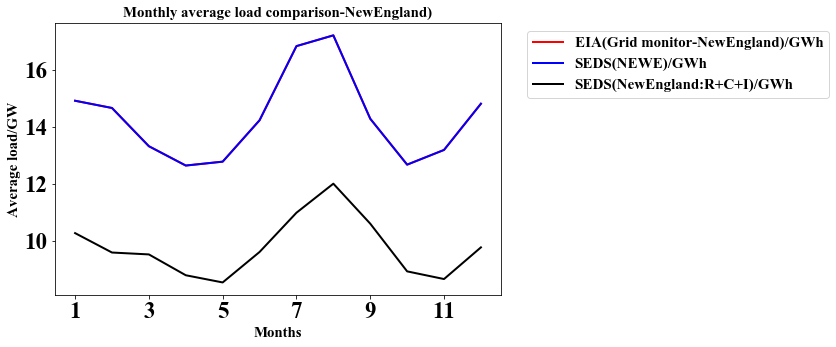

In [27]:
if Switch_compare ==1:    
    result_monthly_all_load = pd.DataFrame()
    result_monthly_all_load['month'] = range(1,13)
    
    if region_id ==0:
        EIA_CA_raw = systemload_new.groupby('month').mean()['Raw EIA load/MW'].tolist()
        EIA_CA_raw = [x/1000 for x in EIA_CA_raw]         
        SEDS_CAL = EMM_hourly.groupby('month')['EBA.CAL-ALL.D.H'].mean().tolist()
        SEDS_CAL = [x/1000 for x in SEDS_CAL]
    elif region_id ==1:
        EIA_TX_raw = systemload_new.groupby('month').mean()['Raw EIA load/MW'].tolist()
        EIA_TX_raw = [x/1000 for x in EIA_TX_raw]        
        SEDS_ERCO = EMM_hourly.groupby('month')['EBA.ERCO-ALL.D.H'].mean().tolist()
        SEDS_ERCO = [x/1000 for x in SEDS_ERCO]    
    elif region_id ==2:
        EIA_NewEngland_raw = systemload_new.groupby('month').mean()['Raw EIA load/MW'].tolist()
        EIA_NewEngland_raw = [x/1000 for x in EIA_NewEngland_raw]        
        SEDS_NEWE = EMM_hourly.groupby('month')['EBA.NEWE-ALL.D.H'].mean().tolist()
        SEDS_NEWE = [x/1000 for x in SEDS_NEWE] 
    load_Res = []
    for i in range(1,13):
        load_Res.append(month_ratios.iloc[i-1][1]+month_ratios.iloc[i-1][3]+month_ratios.iloc[i-1][5])
    load_Res = [x/1000 for x in load_Res]
    
    if region_id ==0:
        result_monthly_all_load['EIA_CA_raw_GWh'] = EIA_CA_raw
        result_monthly_all_load['SEDS_CAL_GWh'] = SEDS_CAL
        result_monthly_all_load['SEDS_sum_GWh'] = load_Res
    elif region_id ==1:
        result_monthly_all_load['EIA_TX_raw_GWh'] = EIA_TX_raw
        result_monthly_all_load['SEDS_ERCO_GWh'] = SEDS_ERCO
        result_monthly_all_load['SEDS_sum_GWh'] = load_Res
    elif region_id ==2:
        result_monthly_all_load['EIA_NewEngland_raw_GWh'] = EIA_NewEngland_raw
        result_monthly_all_load['SEDS_NEWE_GWh'] = SEDS_NEWE
        result_monthly_all_load['SEDS_sum_GWh'] = load_Res
    title_name = 'Monthly average load comparison-'+Region+ ')'
    figsize = 8,5
    figure, ax = plt.subplots(figsize=figsize)
    KWtoGW = 1000000
    MWtoGW = 1000
    Months= [x for x in range(1,13)]
    
    if region_id ==0:
        A,=plt.plot(Months,result_monthly_all_load['EIA_CA_raw_GWh'],'-r',label='EIA(Grid monitor-CAMX)/GWh',linewidth=2.0)
        B,=plt.plot(Months,result_monthly_all_load['SEDS_CAL_GWh'],'-b',label='SEDS(CA)/GWh',linewidth=2.0)
        C,=plt.plot(Months,result_monthly_all_load['SEDS_sum_GWh'],'-k',label='SEDS(CA:R+C+I)/GWh',linewidth=2.0)
  
    elif region_id ==1:
        A,=plt.plot(Months,result_monthly_all_load['EIA_TX_raw_GWh'],'-r',label='EIA(Grid monitor-TX)/GWh',linewidth=2.0)
        B,=plt.plot(Months,result_monthly_all_load['SEDS_ERCO_GWh'],'-b',label='SEDS(ERCT)/GWh',linewidth=2.0)
        C,=plt.plot(Months,result_monthly_all_load['SEDS_sum_GWh'],'-k',label='SEDS(TX:R+C+I)/GWh',linewidth=2.0)
    elif region_id ==2:
        A,=plt.plot(Months,result_monthly_all_load['EIA_NewEngland_raw_GWh'],'-r',label='EIA(Grid monitor-NewEngland)/GWh',linewidth=2.0)
        B,=plt.plot(Months,result_monthly_all_load['SEDS_NEWE_GWh'],'-b',label='SEDS(NEWE)/GWh',linewidth=2.0)
        C,=plt.plot(Months,result_monthly_all_load['SEDS_sum_GWh'],'-k',label='SEDS(NewEngland:R+C+I)/GWh',linewidth=2.0)

    font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 15,
    }
    if region_id ==0 or region_id ==1:
        legend = plt.legend(handles=[A,B,C],prop=font1, bbox_to_anchor=[1.04,1])
    elif region_id ==2:
        legend = plt.legend(handles=[A,B,C],prop=font1, bbox_to_anchor=[1.04,1])
    plt.tick_params(labelsize=23)
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]

    font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 15,
    }
    plt.xlabel('Months',font2)
    plt.ylabel('Average load/GW',font2)
    plt.title(title_name,font1)    
    
    plt.xticks([1, 3, 5,7,9,11])
    plt.show()
    result_monthly_all_load.to_csv('temp_monthly_'+Region+'.csv',index = False)

## 7. Plot the result

### 7.1 Plot the annual info

In [28]:
# systemload_new = pd.read_csv('Gross_load_'+ Region + '_' + Keyword2+'.csv')
# Region

In [29]:
def plot_Load_sectors_scaled(Load_average,Region):
    title_name = 'Annual average scaled load('+Region+ ')'
    figsize = 8,5
    figure, ax = plt.subplots(figsize=figsize)
    KWtoGW = 1000000
    MWtoGW = 1000
    Hours= [x for x in range(0,24)]

    A,=plt.plot(Hours,Load_average['scaled_res_kwh']/KWtoGW,'-r',label='Residential load/GW(scaled)',linewidth=2.0)
    B,=plt.plot(Hours,Load_average['scaled_com_kwh']/KWtoGW,'-b',label='Commercial load/GW(scaled)',linewidth=2.0)
    C,=plt.plot(Hours,Load_average['Raw EIA load/MW']/MWtoGW,'-k',label='Total load/GW(EIA hourly data)',linewidth=2.0)

    font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 15,
    }
    legend = plt.legend(handles=[A,B,C],prop=font1)

    plt.tick_params(labelsize=23)
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]

    font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 15,
    }
    plt.xlabel('Hours',font2)
    plt.ylabel('Load/GW',font2)
    plt.title(title_name,font1)    

    plt.show()
    
    
def plot_Load_sectors_stack_scaled(Load_average,Region):

    title_name = 'Annual average load('+Region+')' 
    font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 18,
    }

    font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 20,
    }


    KWtoGW = 1000000
    MWtoGW = 1000
    Hours= [x for x in range(0,24)]

    figsize = 8,5
    figure, ax = plt.subplots(figsize=figsize)

    plt.plot([],[], color='red', label='Residential load')
    plt.plot([],[], color='blue', label='Commercial load')    
    plt.plot([],[], color='black', label='Other load')

    plt.stackplot(Hours, Load_average['scaled_res_kwh']/KWtoGW,\
                  Load_average['scaled_com_kwh']/KWtoGW,\
                  Load_average['scaled_other_load/KW']/KWtoGW,\
                  colors=['red','blue', 'black'])
    # plt.legend()
    plt.legend(loc=2, prop={'size': 12})
    plt.tick_params(labelsize=16)
    plt.title(title_name,font1)
    plt.xlabel('Hours',font2)
    plt.ylabel('Load/GW',font2)
    plt.show()
    figure.savefig(Region+'_stack.png')
    
def plot_Peak_yearly(CA_load):

    CA_load_weekend = CA_load[CA_load['weekend']==1]
    CA_load_weekend_average = CA_load_weekend.groupby('hour').mean()

    CA_load_weekday = CA_load[CA_load['weekend']==0]
    CA_load_weekday_average = CA_load_weekday.groupby('hour').mean()

    CA_load_peak_average = CA_load.groupby('day_of_year').mean()
    CA_load_peak_average_list = (CA_load_peak_average['Raw EIA load/MW'].tolist())
    day_year = CA_load_peak_average_list.index(max(CA_load_peak_average_list))
    CA_load_peak = CA_load[CA_load['day_of_year']==day_year]

    KWtoGW = 1000000
    Hours= [x for x in range(0,24)]

    figsize = 8,5
    figure, ax = plt.subplots(figsize=figsize)


    plt.plot([],[], color='red', label='Residential load (scaled)/GW')
    plt.plot([],[], color='blue', label='Commercial load (scaled)/GW')    
    plt.plot([],[], color='black', label='Other load (scaled)/GW')


    plt.stackplot(Hours, CA_load_peak['scaled_res_kwh']/KWtoGW, \
                 CA_load_peak['scaled_com_kwh']/KWtoGW,\
                  CA_load_peak['scaled_other_load/KW']/KWtoGW,\
                  colors=['red','blue','black'])
    
    font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 15,
    }

    plt.tick_params(labelsize=23)
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]

    font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 15,
    }
    
    title_name = 'Peak load' + '(' + Region+ '/yearly)'
    plt.legend(loc=2, prop={'size': 12})
    plt.tick_params(labelsize=16)
    plt.title(title_name,font1)
    plt.xlabel('Hours',font2)
    plt.ylabel('Load/GWh',font2)
    plt.show()
    return CA_load_peak
    

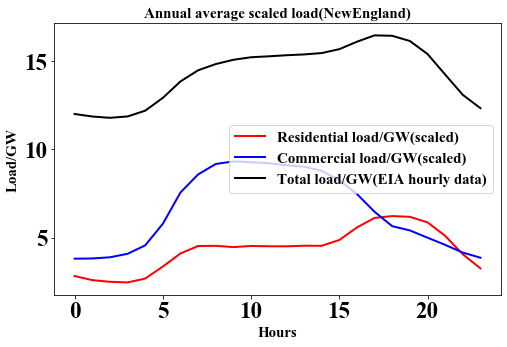

Scaled Commmercial ratio = 0.45687106943415534
Scaled Residential ratio = 0.30286948694047533
Scaled Other load ratio = 0.24025944362536936
Scaled Commmercial ratio = 0.3288535152867704
Scaled Residential ratio = 0.49823833558033775


In [30]:
systemload_average_all = systemload_new.groupby('hour').mean()
plot_Load_sectors_scaled(systemload_average_all,Region_list[region_id])
plot_Load_sectors_stack_scaled(systemload_average_all,Region_list[region_id])
# plot_Peak_yearly(systemload_new)

print('Scaled Commmercial ratio = '+str(systemload_average_all['scaled_com_kwh'].sum()/1000/systemload_average_all['Raw EIA load/MW'].sum()))
print('Scaled Residential ratio = '+str(systemload_average_all['scaled_res_kwh'].sum()/1000/systemload_average_all['Raw EIA load/MW'].sum()))
print('Scaled Other load ratio = '+str(systemload_average_all['scaled_other_load/KW'].sum()/1000/systemload_average_all['Raw EIA load/MW'].sum()))

print('Scaled Commmercial ratio = '+str(systemload_new['scaled_res_kwh_nighttime0'].sum()/1000/systemload_new['Daytime EIA load/MW'].sum()))
print('Scaled Residential ratio = '+str(systemload_new['scaled_com_kwh_nighttime0'].sum()/1000/systemload_new['Daytime EIA load/MW'].sum()))

In [31]:
systemload_new.head()

hour           Date/Time  day_of_year                date  month  weekend  \
0     0 2016-01-01 01:00:00            1 2016-01-01 00:00:00      1    False   
1     1 2016-01-01 02:00:00            1 2016-01-01 01:00:00      1    False   
2     2 2016-01-01 03:00:00            1 2016-01-01 02:00:00      1    False   
3     3 2016-01-01 04:00:00            1 2016-01-01 03:00:00      1    False   
4     4 2016-01-01 05:00:00            1 2016-01-01 04:00:00      1    False   

   commercial_load_kwh  residential_load_kwh  ComAndRes_load_kwh  \
0         9.703406e+05          5.059105e+06        6.029446e+06   
1         9.646911e+05          4.626240e+06        5.590931e+06   
2         9.813145e+05          4.443455e+06        5.424769e+06   
3         1.013503e+06          4.385557e+06        5.399060e+06   
4         1.162764e+06          4.373989e+06        5.536753e+06   

   residential_load_kwh_EE  ...  Raw EIA load/MW  Daytime EIA load/MW  \
0             2.922983e+06  ...            12503                    0   
1             2.658254e+06  ...            12241                    0   
2             2.550141e+06  ...            11824                    0   
3             2.525335e+06  ...            11616                    0   
4             2.522564e+06  ...            11626                    0   

   raw other load/KW  scaled_res_kwh  scaled_com_kwh  \
0         12503000.0    3.196128e+06    3.989023e+06   
1         12241000.0    2.922662e+06    4.134711e+06   
2         11824000.0    2.807186e+06    4.184480e+06   
3         11616000.0    2.770609e+06    4.161651e+06   
4         11626000.0    2.763300e+06    4.334176e+06   

   scaled_res_kwh_nighttime0  scaled_com_kwh_nighttime0  scaled_res_kwh_EE  \
0                        0.0                        0.0       1.846616e+06   
1                        0.0                        0.0       1.679372e+06   
2                        0.0                        0.0       1.611071e+06   
3                        0.0                        0.0       1.595399e+06   
4                        0.0                        0.0       1.593649e+06   

   scaled_other_load/KW  EIA load consider EE/MW  
0          5.317850e+06             11153.488753  
1          5.183627e+06             10997.710573  
2          4.832334e+06             10627.884870  
3          4.683741e+06             10440.790880  
4          4.528523e+06             10456.348322  

[5 rows x 21 columns]

### 7.2 Plot the seasonal info

In [32]:
def plot_seasonly_average_load(CA_load_full):
    for season in range(1,5):
        if season ==1:
            season_name = 'Spring'
            CA_load = CA_load_full[(CA_load_full['month'] <= 3)]
        elif season ==2:
            season_name = 'Summer'
            CA_load = CA_load_full[(CA_load_full['month'] >= 4) & (CA_load_full['month'] >= 6)]
        elif season ==3:
            season_name = 'Autumn'
            CA_load = CA_load_full[(CA_load_full['month'] >= 7) & (CA_load_full['month'] >= 9)]
        elif season==4:
            season_name = 'Winter'
            CA_load = CA_load_full[(CA_load_full['month'] >= 10)]

        CA_load_average = CA_load.groupby('hour').mean()


        KWtoGW = 1000000
        Hours= [x for x in range(0,24)]

        figsize = 7,4.5
        figure, ax = plt.subplots(figsize=figsize)
        plt.plot([],[], color='red', label='Residential load (scaled)/GW')
        plt.plot([],[], color='blue', label='Commercial load (scaled)/GW')
        plt.plot([],[], color='black', label='Other load (scaled)/GW')


        plt.stackplot(Hours, CA_load_average['scaled_res_kwh']/KWtoGW, \
                     CA_load_average['scaled_com_kwh']/KWtoGW,\
                      CA_load_average['scaled_other_load/KW']/KWtoGW,\
                      colors=['red','blue','black'])

        font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }


        font2 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }
        
        title_name = 'Average load' + '(' + Region+ ', season = '+str(season_name) + ')'
        plt.legend(loc=2, prop={'size': 12})
        plt.tick_params(labelsize=16)
        plt.title(title_name,font1)
        plt.xlabel('Hours',font2)
        plt.ylabel('Load/GWh',font2)
        plt.show()
def plot_seasonly_peak_load(CA_load_full):
    for season in range(1,5):
        if season ==1:
            season_name = 'Spring'
            CA_load = CA_load_full[(CA_load_full['month'] <= 3)]
        elif season ==2:
            season_name = 'Summer'
            CA_load = CA_load_full[(CA_load_full['month'] >= 4) & (CA_load_full['month'] >= 6)]
        elif season ==3:
            season_name = 'Autumn'
            CA_load = CA_load_full[(CA_load_full['month'] >= 7) & (CA_load_full['month'] >= 9)]
        elif season==4:
            season_name = 'Winter'
            CA_load = CA_load_full[(CA_load_full['month'] >= 10)]
        

        
        CA_load_weekend = CA_load[CA_load['weekend']==1]
        CA_load_weekend_average = CA_load_weekend.groupby('hour').mean()

        CA_load_weekday = CA_load[CA_load['weekend']==0]
        CA_load_weekday_average = CA_load_weekday.groupby('hour').mean()

        CA_load_peak_average = CA_load.groupby('day_of_year').mean()
        CA_load_peak_average_list = (CA_load_peak_average['Raw EIA load/MW'].tolist())

        day_year = CA_load_peak_average_list.index(max(CA_load_peak_average_list))
        day_year = CA_load_peak_average.index.tolist()[day_year]
        CA_load_peak = CA_load[CA_load['day_of_year']==day_year]

        KWtoGW = 1000000
        Hours= [x for x in range(0,24)]

        figsize = 6,3.5
        figure, ax = plt.subplots(figsize=figsize)
        plt.plot([],[], color='red', label='Residential load (scaled)/GW')
        plt.plot([],[], color='blue', label='Commercial load (scaled)/GW')
        plt.plot([],[], color='black', label='Other load (scaled)/GW')


        plt.stackplot(Hours, CA_load_peak['scaled_res_kwh']/KWtoGW, \
                     CA_load_peak['scaled_com_kwh']/KWtoGW,\
                      CA_load_peak['scaled_other_load/KW']/KWtoGW,\
                      colors=['red','blue','black'])

        font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }


        font2 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }
        
        title_name = 'Peak load' + '(' + Region+ ', season = '+str(season_name) + ')'
        plt.legend(loc=2, prop={'size': 12})
        plt.tick_params(labelsize=16)
        plt.title(title_name,font1)
        plt.xlabel('Hours',font2)
        plt.ylabel('Load/GWh',font2)
        plt.show()
        
def plot_seasonly_peak_load_nolegend(CA_load_full):
    for season in range(1,5):
        if season ==1:
            season_name = 'Spring'
            CA_load = CA_load_full[(CA_load_full['month'] <= 3)]
        elif season ==2:
            season_name = 'Summer'
            CA_load = CA_load_full[(CA_load_full['month'] >= 4) & (CA_load_full['month'] >= 6)]
        elif season ==3:
            season_name = 'Autumn'
            CA_load = CA_load_full[(CA_load_full['month'] >= 7) & (CA_load_full['month'] >= 9)]
        elif season==4:
            season_name = 'Winter'
            CA_load = CA_load_full[(CA_load_full['month'] >= 10)]
        

        
        CA_load_weekend = CA_load[CA_load['weekend']==1]
        CA_load_weekend_average = CA_load_weekend.groupby('hour').mean()

        CA_load_weekday = CA_load[CA_load['weekend']==0]
        CA_load_weekday_average = CA_load_weekday.groupby('hour').mean()

        CA_load_peak_average = CA_load.groupby('day_of_year').mean()
        CA_load_peak_average_list = (CA_load_peak_average['Raw EIA load/MW'].tolist())

        day_year = CA_load_peak_average_list.index(max(CA_load_peak_average_list))
        day_year = CA_load_peak_average.index.tolist()[day_year]
        CA_load_peak = CA_load[CA_load['day_of_year']==day_year]

        KWtoGW = 1000000
        Hours= [x for x in range(0,24)]

        figsize = 6,3.5
        figure, ax = plt.subplots(figsize=figsize)
        plt.plot([],[], color='red', label='Residential load/GW')
        plt.plot([],[], color='blue', label='Commercial load/GW')
        plt.plot([],[], color='black', label='Other load/GW')


        plt.stackplot(Hours, CA_load_peak['scaled_res_kwh']/KWtoGW, \
                     CA_load_peak['scaled_com_kwh']/KWtoGW,\
                      CA_load_peak['scaled_other_load/KW']/KWtoGW,\
                      colors=['red','blue','black'])

        font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }


        font2 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }
        
        title_name = 'Peak load' + '(' + Region+ ', season = '+str(season_name) + ')'
        ax.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)     ##设置ax4中legend的位置，将其放在图外

        plt.tick_params(labelsize=16)
        plt.title(title_name,font1)
        plt.xlabel('Hours',font2)
        plt.ylabel('Load/GWh',font2)
        plt.show()
        
def plot_seasonly_peak_load_integrated(CA_load_full,region):
    fig, ax_list = plt.subplots(2, 2, figsize=(10,8))
#     fig,ax = plt.subplots(nrows=2, ncols=2)
#     axes = ax.flatten()
    for season in range(1,5):
        if season ==1:
            season_name = 'Spring'
            CA_load = CA_load_full[(CA_load_full['month'] <= 3)]
        elif season ==2:
            season_name = 'Summer'
            CA_load = CA_load_full[(CA_load_full['month'] >= 4) & (CA_load_full['month'] >= 6)]
        elif season ==3:
            season_name = 'Autumn'
            CA_load = CA_load_full[(CA_load_full['month'] >= 7) & (CA_load_full['month'] >= 9)]
        elif season==4:
            season_name = 'Winter'
            CA_load = CA_load_full[(CA_load_full['month'] >= 10)]
        

        
        CA_load_weekend = CA_load[CA_load['weekend']==1]
        CA_load_weekend_average = CA_load_weekend.groupby('hour').mean()

        CA_load_weekday = CA_load[CA_load['weekend']==0]
        CA_load_weekday_average = CA_load_weekday.groupby('hour').mean()

        CA_load_peak_average = CA_load.groupby('day_of_year').mean()
        CA_load_peak_average_list = (CA_load_peak_average['Raw EIA load/MW'].tolist())

        day_year = CA_load_peak_average_list.index(max(CA_load_peak_average_list))
        day_year = CA_load_peak_average.index.tolist()[day_year]
        CA_load_peak = CA_load[CA_load['day_of_year']==day_year]

        KWtoGW = 1000000
        Hours= [x for x in range(0,24)]

        print('Season = ' + str(season))
        
        plt.subplot(220+season)
#             df1.plot(ax=ax_list[0], legend=False)
#         figure, ax = plt.subplots(figsize=figsize)
        plt.plot([],[], color='red', label='Residential load/GW')
        plt.plot([],[], color='blue', label='Commercial load/GW')
        plt.plot([],[], color='black', label='Other load/GW')


        plt.stackplot(Hours, CA_load_peak['scaled_res_kwh']/KWtoGW, \
                     CA_load_peak['scaled_com_kwh']/KWtoGW,\
                      CA_load_peak['scaled_other_load/KW']/KWtoGW,\
                      colors=['red','blue','black'])
           

        font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }


        font2 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }
        if season ==1 or season ==3:
            plt.ylabel('Load/GWh',font2)
        if season ==3 or season ==4:
            plt.xlabel('Hours',font2)
        if season ==1:
            plt.legend(loc='upper left') 
            
        if region == 'CA':
            plt.axis([0, 23, 0, 60])
            my_y_ticks = np.arange(0, 61, 20)
            if season==1 or season==4:
                plt.text(18, 50, season_name)
            elif season==2 or season==3:
                plt.text(4, 50, season_name)
        if region == 'TX':
            plt.axis([0, 23, 0, 80]) 
            my_y_ticks = np.arange(0, 81, 20)
            plt.text(18, 70, season_name)
        if region == 'NewEngland':
            plt.axis([0, 23, 0, 20]) 
            my_y_ticks = np.arange(0, 21, 5)
            plt.text(18, 16, season_name)            
        
        plt.yticks(my_y_ticks)
        
    
    plt.show()
    
    
def plot_seasonly_average_load_integrated(CA_load_full,region):
    fig, ax_list = plt.subplots(2, 2, figsize=(10,8))
#     fig,ax = plt.subplots(nrows=2, ncols=2)
#     axes = ax.flatten()
    for season in range(1,5):
        if season ==1:
            season_name = 'Spring'
            CA_load = CA_load_full[(CA_load_full['month'] <= 3)]
        elif season ==2:
            season_name = 'Summer'
            CA_load = CA_load_full[(CA_load_full['month'] >= 4) & (CA_load_full['month'] >= 6)]
        elif season ==3:
            season_name = 'Autumn'
            CA_load = CA_load_full[(CA_load_full['month'] >= 7) & (CA_load_full['month'] >= 9)]
        elif season==4:
            season_name = 'Winter'
            CA_load = CA_load_full[(CA_load_full['month'] >= 10)]
        

        CA_load_average = CA_load.groupby('hour').mean()
        
        KWtoGW = 1000000
        Hours= [x for x in range(0,24)]

        print('Season = ' + str(season))
        
        plt.subplot(220+season)
#             df1.plot(ax=ax_list[0], legend=False)
#         figure, ax = plt.subplots(figsize=figsize)
        plt.plot([],[], color='red', label='Residential load/GW')
        plt.plot([],[], color='blue', label='Commercial load/GW')
        plt.plot([],[], color='black', label='Other load/GW')


        plt.stackplot(Hours, CA_load_average['scaled_res_kwh']/KWtoGW, \
                     CA_load_average['scaled_com_kwh']/KWtoGW,\
                      CA_load_average['scaled_other_load/KW']/KWtoGW,\
                      colors=['red','blue','black'])
           

        font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }


        font2 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }
        if season ==1 or season ==3:
            plt.ylabel('Load/GWh',font2)
        if season ==3 or season ==4:
            plt.xlabel('Hours',font2)
        if season ==1:
            plt.legend(loc='upper left') 
            
        if region == 'CA':
            plt.axis([0, 23, 0, 50])
            my_y_ticks = np.arange(0, 51, 10)
            if season==1 or season==4:
                plt.text(18, 45, season_name)
            elif season==2 or season==3:
                plt.text(4, 45, season_name)
        if region == 'TX':
            plt.axis([0, 23, 0, 60]) 
            my_y_ticks = np.arange(0, 61, 15)
            plt.text(18, 50, season_name)
        if region == 'NewEngland':
            plt.axis([0, 23, 0, 20]) 
            my_y_ticks = np.arange(0, 21, 5)
            plt.text(18, 16, season_name)    
        plt.yticks(my_y_ticks)
        

    plt.show()
    
    
def plot_monthly_average_load_integrated(CA_load_full,region,month_start, month_end):
    fig, ax_list = plt.subplots(2,3, figsize=(12,6))
    for month in range(month_start, month_end):
        
        CA_load = CA_load_full[(CA_load_full['month'] == month)]
        
        CA_load_average = CA_load.groupby('hour').mean()
        
        KWtoGW = 1000000
        Hours= [x for x in range(0,24)]

        print('month = ' + str(month)+'(Month Average)')
        
        if month < 7:
            plt.subplot(230 + month)
        else:
            plt.subplot(230 + month-6)

        plt.plot([],[], color='red', label='R')
        plt.plot([],[], color='blue', label='C')
        plt.plot([],[], color='black', label='O')

        plt.stackplot(Hours, CA_load_average['scaled_res_kwh']/KWtoGW, \
                     CA_load_average['scaled_com_kwh']/KWtoGW,\
                      CA_load_average['scaled_other_load/KW']/KWtoGW,\
                      colors=['red','blue','black'])
           

        font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }


        font2 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }
        if month % 3  ==1: 
            plt.ylabel('Load/GW',font2)
        if month > 9:
            plt.xlabel('Hours',font2)
        if month ==1 or month ==7:
            plt.legend(loc='upper left') 
            
        if region == 'CA':
            plt.axis([0, 23, 0, 50])
            my_y_ticks = np.arange(0, 51, 10)
            plt.text(12, 45, str(month))

        if region == 'TX':
            plt.axis([0, 23, 0, 70]) 
            my_y_ticks = np.arange(0, 71, 15)
            plt.text(18, 60,  str(month))
        if region == 'NewEngland':
            plt.axis([0, 23, 0, 20]) 
            my_y_ticks = np.arange(0, 21, 5)
            plt.text(18, 18,  str(month)) 
        plt.yticks(my_y_ticks)

    plt.show()
    
    
    
def plot_monthly_peak_load_integrated(CA_load_full,region,month_start, month_end):
    fig, ax_list = plt.subplots(2,3, figsize=(12,6))
    
    for month in range(month_start, month_end):        
        CA_load = CA_load_full[(CA_load_full['month'] == month)]
        CA_load_peak_average = CA_load.groupby('day_of_year').mean()
        CA_load_peak_average_list = (CA_load_peak_average['Raw EIA load/MW'].tolist())

        day_year = CA_load_peak_average_list.index(max(CA_load_peak_average_list))
        day_year = CA_load_peak_average.index.tolist()[day_year]
        CA_load_peak = CA_load[CA_load['day_of_year']==day_year]
        
        KWtoGW = 1000000
        Hours= [x for x in range(0,24)]
        print('month = ' + str(month)+'(Month peak)')        
        if month < 7:
            plt.subplot(230 + month)
        else:
            plt.subplot(230 + month-6)

        plt.plot([],[], color='red', label='R')
        plt.plot([],[], color='blue', label='C')
        plt.plot([],[], color='black', label='O')

        plt.stackplot(Hours, CA_load_peak['scaled_res_kwh']/KWtoGW, \
                     CA_load_peak['scaled_com_kwh']/KWtoGW,\
                      CA_load_peak['scaled_other_load/KW']/KWtoGW,\
                      colors=['red','blue','black'])           

        font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }

        font2 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }
        if month % 3  ==1: 
            plt.ylabel('Load/GW',font2)
        if month > 9:
            plt.xlabel('Hours',font2)
        if month ==1 or month ==7:
            plt.legend(loc='upper left') 
            
        if region == 'CA':
            plt.axis([0, 23, 0, 60])
            my_y_ticks = np.arange(0, 61, 10)
            plt.text(12, 55, str(month))

        if region == 'TX':
            plt.axis([0, 23, 0, 80]) 
            my_y_ticks = np.arange(0, 81, 15)
            plt.text(18, 70, str(month))    
        if region == 'NewEngland':
            plt.axis([0, 23, 0, 20]) 
            my_y_ticks = np.arange(0, 21, 5)
            plt.text(18, 18, str(month))     
        plt.yticks(my_y_ticks)

    plt.show()

In [33]:
# plot_seasonly_peak_load(systemload_new)
# plot_seasonly_peak_load_nolegend(systemload_new)
# plot_seasonly_average_load(systemload_new)

In [34]:
# plot_seasonly_average_load_integrated(systemload_new,Region)
# plot_seasonly_peak_load_integrated(systemload_new,Region)

month = 1(Month Average)
month = 2(Month Average)
month = 3(Month Average)
month = 4(Month Average)
month = 5(Month Average)
month = 6(Month Average)


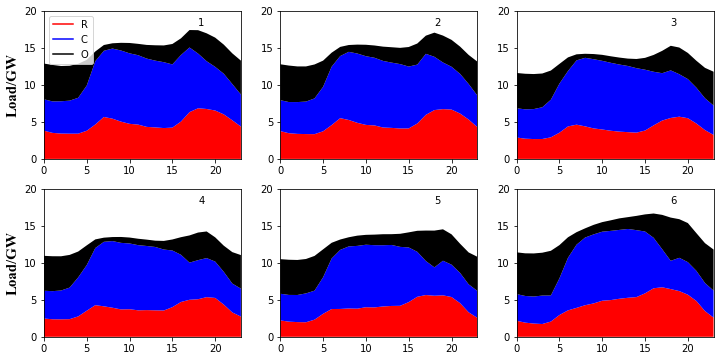

month = 7(Month Average)
month = 8(Month Average)
month = 9(Month Average)
month = 10(Month Average)
month = 11(Month Average)
month = 12(Month Average)


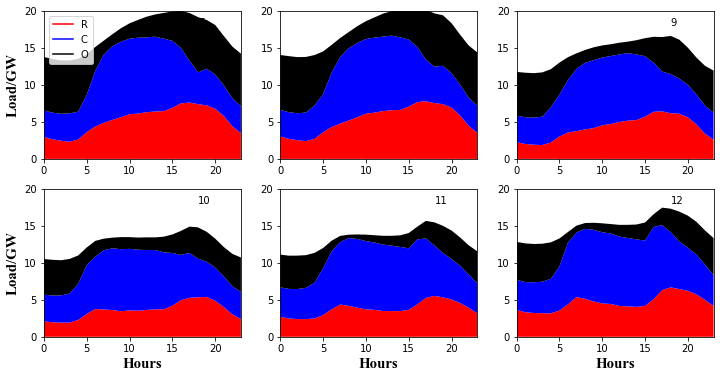

month = 1(Month peak)
month = 2(Month peak)
month = 3(Month peak)
month = 4(Month peak)
month = 5(Month peak)
month = 6(Month peak)


month = 7(Month peak)
month = 8(Month peak)
month = 9(Month peak)
month = 10(Month peak)
month = 11(Month peak)
month = 12(Month peak)


In [35]:
plot_monthly_average_load_integrated(systemload_new,Region,1,7)
plot_monthly_average_load_integrated(systemload_new,Region,7,13)
plot_monthly_peak_load_integrated(systemload_new,Region,1,7)
plot_monthly_peak_load_integrated(systemload_new,Region,7,13)

In [36]:
Region

'NewEngland'

### 7.3 Plot the load duration curve


In [37]:
font1 = {'family':'Times New Roman','weight':'normal','size': 20}

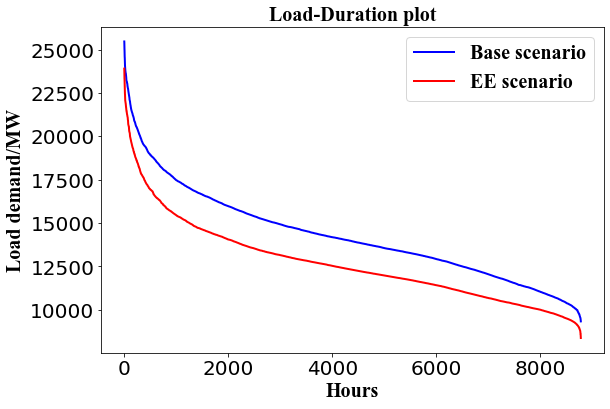

In [38]:
if Switch_EEconsidered==1:
    a= sorted(systemload_new['Raw EIA load/MW'].tolist(), key=None, reverse=True)
    b= sorted(systemload_new['EIA load consider EE/MW'].tolist(), key=None, reverse=True)

    figsize = 9,6
    figure, ax = plt.subplots(figsize=figsize)
    A, = plt.plot(a,'b',label='Base scenario',linewidth=2.0)
    B, = plt.plot(b,'r',label='EE scenario',linewidth=2.0)
    plt.xlabel('Hours',font1)
    plt.ylabel('Load demand/MW',font1)
    plt.title('Load-Duration plot',font1)
    plt.tick_params(labelsize=20)
    legend = plt.legend(handles=[A,B],prop=font1)
    plt.show()

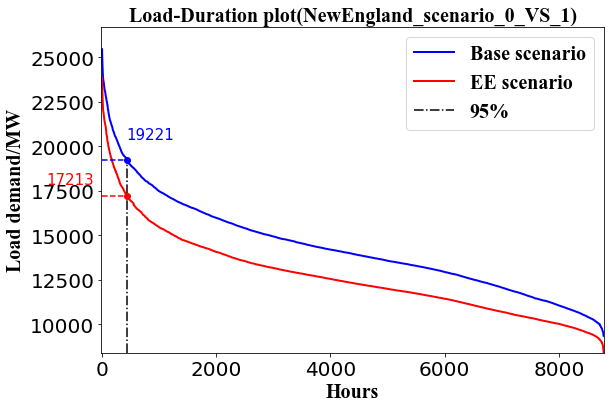

In [39]:
if Switch_EEconsidered==1:
    k = 0.05
    a= sorted(systemload_new['Raw EIA load/MW'].tolist(), key=None, reverse=True)
    b= sorted(systemload_new['EIA load consider EE/MW'].tolist(), key=None, reverse=True)

    figsize = 9,6
    figure, ax = plt.subplots(figsize=figsize)
    A, = plt.plot(a,'b',label='Base scenario',linewidth=2.0)
    B, = plt.plot(b,'r',label='EE scenario',linewidth=2.0)
    plt.xlabel('Hours',font1)
    plt.ylabel('Load demand/MW',font1)
    plt.title('Load-Duration plot(' + Region + '_' + Keyword2+')',font1)
    plt.tick_params(labelsize=20)
    legend = plt.legend(handles=[A,B],prop=font1)
    
    y_base = np.linspace(min(b),a[int(k*len(a))],100)
    x_base = [int(len(a)*k) for y in y_base]
    C, =plt.plot(x_base, y_base, color='k', linestyle='-.',label='95%')  
    
    x_base = np.linspace(0,int(len(a)*k),100)
    y_base = [a[int(len(a)*k)] for x in x_base]
    plt.plot(x_base, y_base, color='b', linestyle='--') 
    plt.text(int(len(a)*k)+400, a[int(len(a)*k)]+1000, '%.0f' %(a[int(len(a)*k)]), ha='center', va= 'bottom',color = 'b',fontsize=15)
    plt.plot(int(len(a)*k), a[int(len(a)*k)], color='b', marker='o')

    y_base = [b[int(len(a)*k)] for x in x_base]
    plt.plot(x_base, y_base, color='r', linestyle='--')
    plt.text(int(len(a)*k)-1000, b[int(len(a)*k)]+500, '%.0f' %(b[int(len(a)*k)]), ha='center', va= 'bottom',color = 'r',fontsize=15)
    plt.plot(int(len(a)*k), b[int(len(a)*k)], color='r', marker='o')
    
    legend = plt.legend(handles=[A,B,C],prop=font1)    
    plt.axis([-10, len(a), min(b),max(a)*1.05])
    plt.show()    

### 7.4 Plot the load distribution

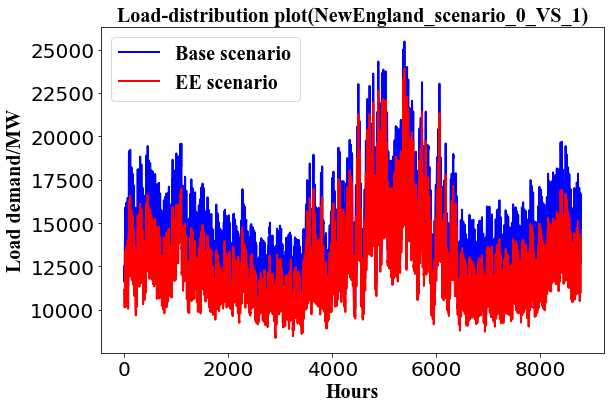

In [40]:

figsize = 9,6
figure, ax = plt.subplots(figsize=figsize)
A, = plt.plot(systemload_new['Raw EIA load/MW'].tolist(),'b',label='Base scenario',linewidth=2.0)
B, = plt.plot(systemload_new['EIA load consider EE/MW'].tolist(),'r',label='EE scenario',linewidth=2.0)
plt.xlabel('Hours',font1)
plt.ylabel('Load demand/MW',font1)
plt.title('Load-distribution plot(' + Region + '_' + Keyword2+')',font1)
plt.tick_params(labelsize=20)
legend = plt.legend(handles=[A,B],prop=font1)
plt.show()
    

### 7.5 Plot the hist of load distribution

In [41]:
plt.hist(systemload_new['Raw EIA load/MW'],color = 'blue', bins=80, alpha=0.5, edgecolor = 'black',label='Base scenario')
plt.hist(systemload_new['EIA load consider EE/MW'], color = 'red', bins=80, alpha=0.5, edgecolor = 'black',label='EE scenario')
plt.legend(loc='best', prop={'size': 12})
plt.xlabel('Load demand/MW',font1)
plt.ylabel('Hours',font1)
plt.tick_params(labelsize=15)
plt.title('Load distribution(' + Region + '_' + Keyword2+')',font1)
plt.show()

### 7.6 Plot the hist of load distribution

In [42]:
Base_list = systemload_new['Raw EIA load/MW'].tolist()
EE_list = systemload_new['EIA load consider EE/MW'].tolist()

Base_sorted_list = sorted(Base_list,reverse=True)
EE_sorted_list = sorted(EE_list,reverse=True)

result_BaseVSEE = pd.DataFrame(index=['Base','EE'])
result_BaseVSEE['Res load/GWh'] = [int(systemload_new.scaled_res_kwh.sum()/1000000),int(systemload_new.scaled_res_kwh_EE.sum()/1000000)]
result_BaseVSEE['Total load/GWh'] = [int(systemload_new['Raw EIA load/MW'].sum()/1000),int(systemload_new['EIA load consider EE/MW'].sum()/1000)]

result_BaseVSEE['Max load/MW'] = [int(max(Base_list)),int(max(EE_list))]
result_BaseVSEE['Min load/MW'] = [int(min(Base_list)),int(min(EE_list))]
result_BaseVSEE['Average load/MW'] = [int(np.mean(Base_list)),int(np.mean(EE_list))]
result_BaseVSEE['Median load/MW'] = [int(np.median(Base_list)),int(np.median(EE_list))]
result_BaseVSEE['Minimum load(Top95%)/MW'] = [int(Base_sorted_list[int(len(EE_list)*0.05)]),int(EE_sorted_list[int(len(EE_list)*0.05)])]
result_BaseVSEE['Average load(Top95%)/MW'] = [int(np.mean(Base_sorted_list[0:int(len(Base_list)*0.05)])),int(np.mean(EE_sorted_list[0:int(len(Base_list)*0.05)]))]

result_BaseVSEE['Max-Threshold(Top95%)/MW'] = [int(max(Base_list)-Base_sorted_list[int(len(EE_list)*0.05)]),int(max(EE_list)-EE_sorted_list[int(len(EE_list)*0.05)])]

result_BaseVSEE

Res load/GWh  Total load/GWh  Max load/MW  Min load/MW  Average load/MW  \
Base         38031          125569        25463         9338            14295   
EE           23932          111470        23897         8382            12690   

      Median load/MW  Minimum load(Top95%)/MW  Average load(Top95%)/MW  \
Base           13949                    19221                    21035   
EE             12308                    17213                    19123   

      Max-Threshold(Top95%)/MW  
Base                      6242  
EE                        6684

In [45]:
df_ComStock_dry8760.columns

Index(['Unnamed: 0', 'out.electricity.cooling.energy_consumption',
       'out.electricity.exterior_lighting.energy_consumption',
       'out.electricity.fans.energy_consumption',
       'out.electricity.heat_recovery.energy_consumption',
       'out.electricity.heat_rejection.energy_consumption',
       'out.electricity.heating.energy_consumption',
       'out.electricity.humidification.energy_consumption',
       'out.electricity.interior_equipment.energy_consumption',
       'out.electricity.interior_lighting.energy_consumption',
       'out.electricity.peak_demand.energy_consumption',
       'out.electricity.pumps.energy_consumption',
       'out.electricity.refrigeration.energy_consumption',
       'out.electricity.total.energy_consumption',
       'out.electricity.water_systems.energy_consumption', 'location',
       '10k_1_climate_zone_upgrade', 'weather_station', 'building_type',
       'month', 'day', 'hour'],
      dtype='object')

In [46]:
df_resstock.columns

Index(['Unnamed: 0', 'epw', 'unit_type', 'upgrade', 'time',
       'Building_Electricity', 'Heating', 'Central_System_Heating', 'Cooling',
       'Central_System_Cooling', 'Water_Heating', 'Interior_Lights',
       'Exterior_Lights', 'Interior_Equipment', 'Heating_Fans', 'Cooling_Fans',
       'Heating_Pumps', 'Cooling_Pumps', 'Central_System_Heating_Pumps',
       'Central_System_Cooling_Pumps', 'Clothes_Washer',
       'Clothes_Dryer_Electric', 'Dishwasher', 'Refrigerator', 'Cooking_Range',
       'Extra_Refrigerator', 'Freezer', 'Plug_Loads', 'House_Fan', 'Range_Fan',
       'Bath_Fan', 'Ceiling_Fan', 'Hot_Tub_Heater_Electric', 'Hot_Tub_Pump',
       'Pool_Heater_Electric', 'Pool_Pump', 'Well_Pump', 'Garage_Lighting',
       'Holiday_Lights'],
      dtype='object')